Notes
- The same library was sequenced twice on the AVITI. The first, on 2023-12-04, was largely a "failed" run with extremely low read count and poor read quality scores. Hence, the entire library pool was re-sequenced on 2023-12-08.
- Goals
  1. Barcode count distributions
  2. Ligation efficiency - relative amounts of Oligo+Y vs. Oligo+R1+Y vs. Oligo+R1+R2+Y vs. Oligo+R1+R2+R3+Y

Status: essentially complete

Optional analyses not performed
- Among reads not matching an expected structure (oligo+(R1+(R2+(R3+)))Y), what are their structures?
  - For example, R1 dimers, R2 dimers, R3 dimers, R1-R3 ligations, oligo-R2 ligations, etc.
- Proportion of pool-only tags in each round

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark

In [2]:
# Python Standard Library modules
import gzip
import itertools
import os
import re
import subprocess
import sys

# Basic SciPy packages
import numpy as np
import scipy
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import plotly.graph_objects as go
import plotly.express as px

# Custom modules
sys.path.append('../scripts')
import string_distances
import parse_barcodes

In [3]:
%watermark
%watermark --conda
%watermark --iversions

Last updated: 2024-01-15T00:58:27.881986-08:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 3.10.0-1160.53.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

conda environment: py3

plotly    : 5.15.0
matplotlib: 3.7.2
numpy     : 1.23.5
re        : 2.2.1
seaborn   : 0.12.2
sys       : 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
pandas    : 2.0.2
scipy     : 1.11.1



In [4]:
%%bash
splitcode --version

splitcode, version 0.29.1


In [5]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20231208')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20231208')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20231208')
DIR_RESULTS = os.path.join(DIR_PROJECT, 'results', '20231208')
# DIR_DATA_1 = os.path.join(DIR_PROJECT, 'data', '20231204')
# DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20231204')
# DIR_PROC_1 = os.path.join(DIR_PROJECT, 'data_proc', '20231204')
# DIR_RESULTS_1 = os.path.join(DIR_PROJECT, 'results', '20231204')

os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)
os.makedirs(DIR_RESULTS, exist_ok=True)

# Constants and Helpers

In [6]:
ROUNDS = ['R1', 'R2', 'R3', 'Y']
STRUCTURES = ['oligo+Y', 'oligo+R1+Y', 'oligo+R1+R2+Y', 'oligo+R1+R2+R3+Y']

# Data

- [Enhanced Sample Sheet](https://docs.google.com/spreadsheets/d/1mykwPx2yhmo0AwmW5-jT6n4OxP4uvRGfa7T5gqjKeH8/)
- [Library sheet](https://docs.google.com/spreadsheets/d/1NeARoDSZU0c5SxCTj2-0UxUu3JVUmXzFHPPD1xkGmKM/)
- [Benchling notebook: 2023-11-29 Single Cell Barcode Troubleshooting, v4 (terminal tag vs. EDTA quench)](https://benchling.com/s/etr-3bKIM8CScL814XrVEUBG)

In [62]:
path_df_data = os.path.join(DIR_RESULTS, 'sample_info.csv')
if not os.path.exists(path_df_data):
    regex_fastq_files = re.compile((
        r'(?P<filename>scBarcode-(?P<basename>(?P<quench>EDTA|NY)_(?P<sample>.*))_R(?P<read>1|2).fastq.gz)'))
    
    files_fastq = sorted([file for file in os.listdir(DIR_DATA) if file.endswith('.fastq.gz')])
    df_data = pd.DataFrame([
        regex_fastq_files.match(file).groupdict() for file in files_fastq]) \
        .astype(dict(read=int))
    
    popen_counts = dict()
    for sample, group in df_data.groupby('sample'):
        filename = group.loc[group['read'] == 1, 'filename'].item()
        cmd = "unpigz -c {path_fastq_raw} | wc -l | awk '{{print $1 / 4}}'".format(path_fastq_raw=os.path.join(DIR_DATA, filename))
        popen_counts[sample] = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    
    df_data['n_reads'] = int(0)
    for sample, popen in popen_counts.items():
        count, err = popen.communicate()
        assert err is None and popen.returncode == 0
        df_data.loc[df_data['sample'] == sample, 'n_reads'] = int(count.decode().strip())
    
    path_library_info = os.path.join(DIR_DATA, '2023-11-30 Amplification and Sequencing of Flow Singlets - Gel Cut.csv')
    df_library_info = (
        pd.read_csv(path_library_info)
        .pipe(lambda df: (
            df.assign(basename=df['Sample'].str.replace('scBarcode-', ''))
            .drop(columns=[c for c in df.columns if c.startswith('Unnamed')])
            .loc[~df['Sample'].isna() & df['To Pool']]
            .rename(columns={'Complexity': 'Complexity (Tapestation)'})
            .astype({'Complexity (Tapestation)': int})
        ))
    )
    
    # from the library sheet, linked above
    df_data = (
        df_data
        .merge(df_library_info[['basename', 'Complexity (Tapestation)']], how='left')
        .sort_values(['basename', 'read'])
        .reset_index(drop=True)
    )
    df_data.to_csv(path_df_data, index=False)
else:
    df_data = pd.read_csv(path_df_data, index_col=False)

In [8]:
print('Total number of paired reads:', df_data['n_reads'].sum() // 2)
display(df_data)

Total number of paired reads: 24104736


filename        basename quench       sample  \
0          scBarcode-EDTA_A2_R1.fastq.gz         EDTA_A2   EDTA           A2   
1          scBarcode-EDTA_A2_R2.fastq.gz         EDTA_A2   EDTA           A2   
2          scBarcode-EDTA_A3_R1.fastq.gz         EDTA_A3   EDTA           A3   
3          scBarcode-EDTA_A3_R2.fastq.gz         EDTA_A3   EDTA           A3   
4          scBarcode-EDTA_B2_R1.fastq.gz         EDTA_B2   EDTA           B2   
5          scBarcode-EDTA_B2_R2.fastq.gz         EDTA_B2   EDTA           B2   
6          scBarcode-EDTA_C3_R1.fastq.gz         EDTA_C3   EDTA           C3   
7          scBarcode-EDTA_C3_R2.fastq.gz         EDTA_C3   EDTA           C3   
8          scBarcode-EDTA_D2_R1.fastq.gz         EDTA_D2   EDTA           D2   
9          scBarcode-EDTA_D2_R2.fastq.gz         EDTA_D2   EDTA           D2   
10         scBarcode-EDTA_E2_R1.fastq.gz         EDTA_E2   EDTA           E2   
11         scBarcode-EDTA_E2_R2.fastq.gz         EDTA_E2   EDTA           E2   
12         scBarcode-EDTA_F3_R1.fastq.gz         EDTA_F3   EDTA           F3   
13         scBarcode-EDTA_F3_R2.fastq.gz         EDTA_F3   EDTA           F3   
14         scBarcode-EDTA_G2_R1.fastq.gz         EDTA_G2   EDTA           G2   
15         scBarcode-EDTA_G2_R2.fastq.gz         EDTA_G2   EDTA           G2   
16         scBarcode-EDTA_G3_R1.fastq.gz         EDTA_G3   EDTA           G3   
17         scBarcode-EDTA_G3_R2.fastq.gz         EDTA_G3   EDTA           G3   
18         scBarcode-EDTA_H2_R1.fastq.gz         EDTA_H2   EDTA           H2   
19         scBarcode-EDTA_H2_R2.fastq.gz         EDTA_H2   EDTA           H2   
20         scBarcode-EDTA_H3_R1.fastq.gz         EDTA_H3   EDTA           H3   
21         scBarcode-EDTA_H3_R2.fastq.gz         EDTA_H3   EDTA           H3   
22  scBarcode-NY_A4_gt-220bp_R1.fastq.gz  NY_A4_gt-220bp     NY  A4_gt-220bp   
23  scBarcode-NY_A4_gt-220bp_R2.fastq.gz  NY_A4_gt-220bp     NY  A4_gt-220bp   
24  scBarcode-NY_B4_gt-220bp_R1.fastq.gz  NY_B4_gt-220bp     NY  B4_gt-220bp   
25  scBarcode-NY_B4_gt-220bp_R2.fastq.gz  NY_B4_gt-220bp     NY  B4_gt-220bp   
26  scBarcode-NY_C4_lt-220bp_R1.fastq.gz  NY_C4_lt-220bp     NY  C4_lt-220bp   
27  scBarcode-NY_C4_lt-220bp_R2.fastq.gz  NY_C4_lt-220bp     NY  C4_lt-220bp   
28  scBarcode-NY_D4_lt-220bp_R1.fastq.gz  NY_D4_lt-220bp     NY  D4_lt-220bp   
29  scBarcode-NY_D4_lt-220bp_R2.fastq.gz  NY_D4_lt-220bp     NY  D4_lt-220bp   
30  scBarcode-NY_E4_lt-220bp_R1.fastq.gz  NY_E4_lt-220bp     NY  E4_lt-220bp   
31  scBarcode-NY_E4_lt-220bp_R2.fastq.gz  NY_E4_lt-220bp     NY  E4_lt-220bp   
32       scBarcode-NY_G4_all_R1.fastq.gz       NY_G4_all     NY       G4_all   
33       scBarcode-NY_G4_all_R2.fastq.gz       NY_G4_all     NY       G4_all   
34       scBarcode-NY_H4_all_R1.fastq.gz       NY_H4_all     NY       H4_all   
35       scBarcode-NY_H4_all_R2.fastq.gz       NY_H4_all     NY       H4_all   

    read  n_reads  Complexity (Tapestation)  
0      1   135884                    590000  
1      2   135884                    590000  
2      1  1257782                   3570000  
3      2  1257782                   3570000  
4      1  1104986                   3770000  
5      2  1104986                   3770000  
6      1   513192                   1870000  
7      2   513192                   1870000  
8      1  1730567                   4830000  
9      2  1730567                   4830000  
10     1  1232710                   3330000  
11     2  1232710                   3330000  
12     1   495288                   1530000  
13     2   495288                   1530000  
14     1   673366                   1950000  
15     2   673366                   1950000  
16     1   585039                   1630000  
17     2   585039                   1630000  
18     1   730435                   2430000  
19     2   730435                   2430000  
20     1  1499438                   5000000  
21     2  1499438                   5000000  
22     1  117

## Check sequencing depth

Mostly linear relationship between Tapestation-estimated library complexity and number of reads obtained. Only 2 samples from the terminal quench strategy (`C4_lt-220bp` and `D4_lt-220bp`) are moderately undersampled.

In [9]:
fig = px.scatter(
    df_data,
    x='Complexity (Tapestation)',
    y='n_reads',
    color='sample',
    facet_col='quench'
)

# set height to ensure that all samples are shown in legend without need for scrolling
fig.update_layout(height=450, margin=dict(l=10, r=10, b=10, t=20))
fig.show()

# Alternative non-interactive plot using seaborn
# g = sns.relplot(
#     kind='scatter',
#     data=df_data.loc[df_data['read'] == 1],
#     x='Complexity (Tapestation)',
#     y='n_reads',
#     hue='sample',
#     col='quench',
#     facet_kws=dict(sharex=False, sharey=False)
# )

# FastQC

Expectations
- Read 1: good sequence diversity due to UMIs on the oligo
- Read 2: near total duplication from each sample, since all barcodes from the same nucleus should have the same R1, R2, R3, and NYLigOdd tags

In [10]:
%%bash -s {DIR_DATA} {DIR_PROC}
DIR_DATA="$1"
DIR_PROC="$2"
source ~/.bashrc
DIR_FASTQC_OUT="$DIR_PROC/fastqc"
if [ ! -d "$DIR_FASTQC_OUT" ]; then
    mkdir "$DIR_PROC/fastqc"
    cd "$DIR_DATA"
    conda activate chipdip
    fastqc *.fastq.gz -t 20 -q -o "$DIR_FASTQC_OUT"
fi

# Check read structure

Expected read structures (see also Benchling DNA sequence: [Oligo (PC50_12merUMI) + R1-R3 + NYLigOdd PCR Product (2Puni + 2Pbc)](https://benchling.com/s/seq-uec4dPutBQPpgn6aNbXV))

| Component                                 | Length | R1 coordinates | R2 coordinates |
| ----------------------------------------- | ------ | -------------- | -------------- |
| 2Puni adapter, remainder                  | 49     | n/a            | 118:167        |
| 2Puni adapter, continued                  | 10     | n/a            | 108:118        |
| 2Puni adapter, Illumina universal adapter | 11     | n/a            | 97-98:108-109  |
| Oligo UMI                                 | 12     | 0:12           | 85-86:97-98    |
| LigEven / Even overhang                   | 7      | 12:19          | 78-79:85-86    |
| R1 unique sequence                        | 16     | 19:35          | 62-63:78-79    |
| LigR1 / R1 overhang                       | 7      | 35:42          | 55-56:62-63    |
| R2 unique sequence                        | 16     | 42:58          | 39-40:55-56    |
| LigR2 / R2 overhang                       | 7      | 58:65          | 32-33:39-40    |
| R3 unique sequence                        | 16     | 65:81          | 16-17:32-33    |
| LigR3 / R3 overhang                       | 7      | 81:88          | 9-10:16-17     |
| NYLigOddStg (rows A-B) unique sequence    | 9-10   | 88:97-98       | 0:9-10         |
| 2Pbc adapter, Illumina universal adapter  | 11     | 97-98:108-109  | n/a            |

Note: see the splitcode config file for the subsequences of the 2Puni and 2Pbc adapters that are identified.

This sequencing run was acquired with a read 1 length of 120 bp and read 2 length of 180 bp --> can use up to 22 bp for the Illumina adapter for read 1, and all of the adapter for read 2.

## Check terminal tags used

Used wells A1-B12 from a really old NYLigOdd plate --> verify that the wells are in row-major order as expected.

Splitcode config summary: only detect terminal tags associated with a preceeding LigEven/LigR1/LigR2/LigR3 overhang and a following Illumina sequencing adapter sequence.
- I do not allow any errors.
  - This is only an initial QC step, so I do not care to detect the terminal tag in all reads.
  - My initial config file `splitcode_config-Y_r1.tsv` led to extremely poor (<50%) tag identification for samples NY_A4_gt-220bp, EDTA_C3, and NY_H4_all.
    - Ligation overhangs: 1 edit distance
      - <span style="color:red">Somehow switching to 1 hamming distance improves identification for some samples</span>
    - Terminal tags: [maximal hamming distances allowed](https://docs.google.com/spreadsheets/d/1ufkFUfiefmgEtHqwCRk77iJ_fARnvLlxe63xoEo7peU) = 2 for terminal tags with 9 or 10 bp of unique sequence, 1 for terminal tags with 11 bp of unique sequence, and 0 for terminal tags with 12 bp of unique sequence)
    - Illumina adaptor: 2 edit distance
      - <span style="color:red">Changing this to 0 does not significantly change identification, even though presumably allowing edits here could lead to more false-positives than reducing edit distance allowed for the ligation overhangs. </span> From [splitcode documentation](https://splitcode.readthedocs.io/en/latest/user_guide_tags.html#error-distances-tolerance):
        > Be careful when using indels, e.g. the matched sequence might include extra bps at the beginning since those might technically count as “insertions” (since splitcode proceeds from the beginning to the end of a read to find matches).

Conclusions
- All the mode terminal tags are within indices 1-24.
- All EDTA-quenched samples have a mode terminal tag that is at least 215x more common than the 2nd most common terminal tag.
- All EDTA-quenched samples and >220 bp gel-cut NY-quench samples have a mode terminal tag with a `LigR3` overhang.

In [11]:
path_config = os.path.join(DIR_AUX, 'splitcode_config-Y_r1_strict.tsv')

In [12]:
%%bash -s '{DIR_DATA}' '{DIR_PROC}' '{path_config}'
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"

echo "Using config $PATH_CONFIG"

for path_R1 in "$DIR_DATA"/*R1.fastq.gz; do
    SAMPLE="$(echo "$path_R1" | grep -o -E -e '(EDTA|NY)_[A-H][0-9]+.*_R1')"
    path_counts="${DIR_PROC}/terminal_tag_counts-${SAMPLE}.tsv"

    if [ ! -f "$path_counts" ]; then
        splitcode -c "$PATH_CONFIG" \
            --nFastqs=1 --assign --no-outb -t 8 \
            --mapping=/dev/stdout --output=/dev/null \
            "$path_R1" |
            cut -f 2,3 |
            sed -E -e 's/.*(Lig[^,]+,NY[^,]+)$/\1/' |
            awk '{arr[$1]+=$2} END {for (key in arr) printf("%s\t%s\n", key, arr[key])}' |
            sort -k2nr,2 -k1,1 > "$path_counts"
    fi
    
    # output = tab-delimited file with 2 columns, sorted in descending order by column 2:
    # - column 1 = terminal tag, including its overhang (e.g., LigR3,NYTopStg_4)
    # - column 2 = read count
done

Using config /central/groups/guttman/btyeh/scBarcode/data_aux/20231208/splitcode_config-Y_r1_strict.tsv


In [13]:
df_terminal_tags_r1 = []
for sample in df_data['basename'].unique():
    path_analysis = os.path.join(DIR_PROC, f'terminal_tag_counts-{sample}_R1.tsv')
    df_terminal_tags_r1.append(
        pd.read_csv(path_analysis, sep='\t', header=None, names=['tag', 'count']) \
            .assign(sample=sample)
    )
df_terminal_tags_r1 = pd.concat(df_terminal_tags_r1, axis=0, ignore_index=True)
df_terminal_tags_r1['Y'] = df_terminal_tags_r1['tag'].str.extract('NYStgTop_(\d+)').astype(int)
df_terminal_tags_r1['overhang'] = df_terminal_tags_r1['tag'].str.extract('(Lig[^,]+)')

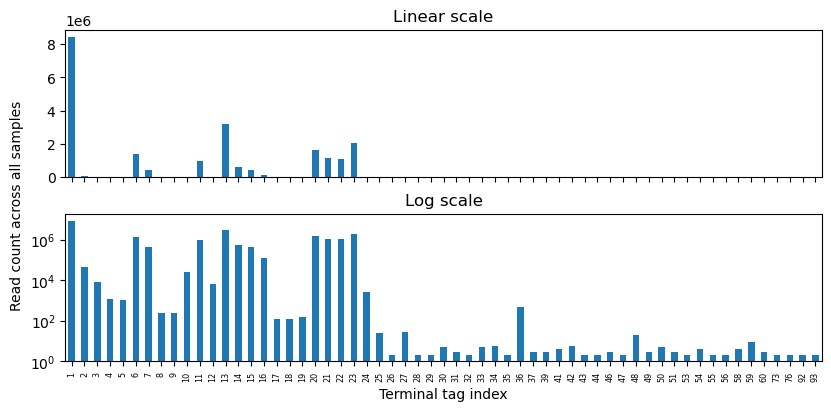

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True, sharey=False, constrained_layout=True)
df_terminal_tags_r1.groupby('Y')['count'].sum().plot(kind='bar', log=False, ax=axs[0])
df_terminal_tags_r1.groupby('Y')['count'].sum().plot(kind='bar', log=True, ax=axs[1])
fig.text(-0.02, 0.5, 'Read count across all samples', va='center', rotation='vertical')
axs[0].set(title='Linear scale')
axs[1].set(title='Log scale', xlabel='Terminal tag index')
axs[1].xaxis.set_tick_params(labelsize='xx-small')

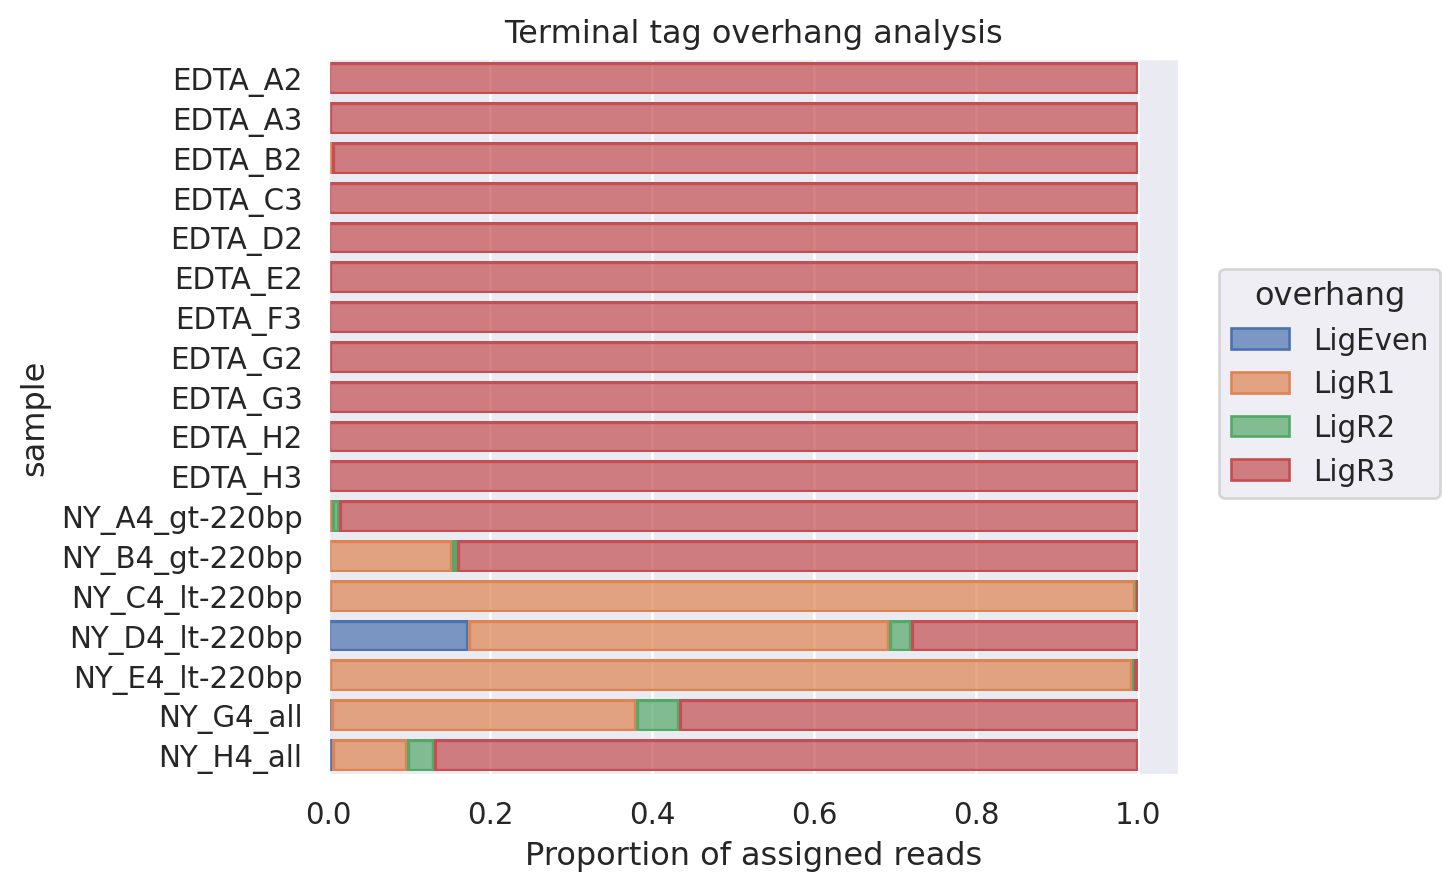

In [15]:
g = (
    so.Plot(
        (
            df_terminal_tags_r1
            .groupby(['sample', 'overhang'])['count'].sum()
            .reset_index()
            .groupby('sample', group_keys=False)
            .apply(lambda df: df.assign(proportion=df['count']/df['count'].sum()))
        ),
        y='sample',
        x='proportion',
        color='overhang')
    .add(so.Bar(), so.Stack())
    .label(
        x='Proportion of assigned reads',
        title='Terminal tag overhang analysis',
    )
)
g.save(
    os.path.join(DIR_RESULTS, 'terminal tag overhang distribution.png'),
    dpi=300,
    bbox_inches='tight'
)

In [16]:
df_terminal_tags_r1_summary = (
    df_terminal_tags_r1
    .groupby('sample')['count'].sum()
    .to_frame().reset_index()
    .merge(df_data[['basename', 'n_reads']].drop_duplicates().rename(columns=dict(basename='sample')))
    .pipe(lambda df: df.assign(proportion_counted=df['count']/df['n_reads']))
)

# most common terminal tag (combination of overhang + unique sequence)
df_terminal_tags_r1_summary = df_terminal_tags_r1_summary.merge(
    (
        df_terminal_tags_r1
        .groupby('sample', group_keys=True)
        .apply(lambda group: (
            group
            .sort_values('count', ascending=False)
            .head(1)[['sample', 'Y', 'overhang']]
        )).reset_index(drop=True)
        .rename(columns={'Y': 'mode_Y-tag_Y', 'overhang': 'mode_Y-tag_overhang'})
    ),
    how='inner'
)

# ratio of count of most common terminal tag to next most common terminal tag
df_terminal_tags_r1_summary = df_terminal_tags_r1_summary.merge(
    (
        df_terminal_tags_r1
        .sort_values(['sample', 'count'], ascending=False)
        .groupby('sample')['count']
        .agg(**{'ratio_mode_to_next': lambda x: x.iloc[0]/x.iloc[1], 'mode_Y-tag_count': 'max'})
        .reset_index()
    ),
    how='inner'
)

In [17]:
df_terminal_tags_r1_summary

sample    count  n_reads  proportion_counted  mode_Y-tag_Y  \
0          EDTA_A2   125081   135884            0.920498            16   
1          EDTA_A3  1102998  1257782            0.876939            22   
2          EDTA_B2   979206  1104986            0.886171            11   
3          EDTA_C3   466056   513192            0.908151            23   
4          EDTA_D2  1534668  1730567            0.886801            20   
5          EDTA_E2  1123790  1232710            0.911642            21   
6          EDTA_F3   443760   495288            0.895964            15   
7          EDTA_G2   586934   673366            0.871642            14   
8          EDTA_G3   517762   585039            0.885004            23   
9          EDTA_H2   664501   730435            0.909733            13   
10         EDTA_H3  1376945  1499438            0.918307             6   
11  NY_A4_gt-220bp  1078006  1176740            0.916095            23   
12  NY_B4_gt-220bp   280187   322647            0.868401             1   
13  NY_C4_lt-220bp  2830322  3262381            0.867563             1   
14  NY_D4_lt-220bp   312456   380883            0.820346             1   
15  NY_E4_lt-220bp  4461852  4895777            0.911367             1   
16       NY_G4_all   766397   894664            0.856631             7   
17       NY_H4_all  2920772  3212957            0.909060            13   

   mode_Y-tag_overhang  ratio_mode_to_next  mode_Y-tag_count  
0                LigR3          897.244604            124717  
1                LigR3         1691.955453           1101463  
2                LigR3          215.842759            973235  
3                LigR3          614.005284            464802  
4                LigR3         7907.850515           1534123  
5                LigR3          352.817952           1116316  
6                LigR3          313.429483            442249  
7                LigR3          602.254377            584789  
8                LigR3         3193.969136            517423  
9                LigR3          752.560726            663006  
10               LigR3         4341.640379           1376300  
11               LigR3          104.867784           1039030  
12               LigR3            4.189136            183082  
13               LigR1          532.007371           2814851  
14               LigR1            1.859395            162169  
15               LigR1          190.464681           4424685  
16               LigR3            1.479319            425819  
17               LigR3            9.333583           2528085

# Count barcodes

1. Add barcode and UMI to read name
   - For config file with separate overhangs: `@read::[LigEven][R1Top_<R1>][LigR1][R2Top_<R2>][LigR2][R3Top_<R3>][LigR3][NYTop_<Y>][Illumina][2Pbc] RX:Z:<umi>`
   - For config file with in-tag overhangs: `@read::[R1Top_<R1>][R2Top_<R2>][R3Top_<R3>][NYTop_<Y>][Illumina][2Pbc] RX:Z:<umi>`
2. Calculate barcode counts

## Tag identification by splitcode

In [18]:
splitcode_configs = (
    'oligo+R1+R2+R3+Y_overhangs-in-tag_r1',
    'oligo+R1+R2+R3+Y_overhangs-separate_r1',
    'oligo+R1+R2+Y_overhangs-in-tag_r1',
    'oligo+R1+R2+Y_overhangs-separate_r1',
    'oligo+R1+Y_overhangs-in-tag_r1',
    'oligo+R1+Y_overhangs-separate_r1',
    'oligo+Y_overhangs-in-tag_r1',
    'oligo+Y_overhangs-separate_r1',
    'all-expected_overhangs-in-tag_r1',
    'all-expected_overhangs-separate_r1'
)

In [19]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_AUX} {DIR_PROJECT}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_AUX="$3"
DIR_PROJECT="$4"

declare -a SPLITCODE_CONFIGS=(
    'oligo+R1+R2+R3+Y_overhangs-in-tag_r1'
    'oligo+R1+R2+R3+Y_overhangs-separate_r1'
    'oligo+R1+R2+Y_overhangs-in-tag_r1'
    'oligo+R1+R2+Y_overhangs-separate_r1'
    'oligo+R1+Y_overhangs-in-tag_r1'
    'oligo+R1+Y_overhangs-separate_r1'
    'oligo+Y_overhangs-in-tag_r1'
    'oligo+Y_overhangs-separate_r1'
    'all-expected_overhangs-in-tag_r1'
    'all-expected_overhangs-separate_r1'
)

PATH_SBATCH="$DIR_PROJECT/scripts/splitcode.sbatch"

for config in "${SPLITCODE_CONFIGS[@]}"; do
    PATH_CONFIG="$DIR_AUX/splitcode_config-${config}.tsv"

    for PATH_R1 in "$DIR_DATA"/*R1.fastq.gz; do
        SAMPLE="$(echo "$PATH_R1" | grep -o -E -e '(EDTA|NY)_[A-H][0-9]+.*_R1' | sed -E -e 's/_R1$//')"
        PATH_MAPPING="$DIR_PROC/mapping-${config}-${SAMPLE}.tsv"
        PATH_SUMMARY="$DIR_PROC/summary-${config}-${SAMPLE}.json"
        PATH_OUTPUT="$DIR_PROC/read_barcodes-${config}-${SAMPLE}.txt.gz"

        if [ ! -f "$PATH_OUTPUT" ]; then

            # submit as SLURM jobs
            PATH_SBATCH_ERROR="$DIR_PROC/sbatch-${config}-${SAMPLE}.err"
            PATH_SBATCH_OUT="$DIR_PROC/sbatch-${config}-${SAMPLE}.out"
            sbatch --error="$PATH_SBATCH_ERROR" --out="$PATH_SBATCH_OUT" \
                "$PATH_SBATCH" \
                "$PATH_CONFIG" "$PATH_MAPPING" "$PATH_SUMMARY" "$PATH_OUTPUT" "$PATH_R1"

            # run locally
            # splitcode -c "$PATH_CONFIG" \
            #     --nFastqs=1 --assign --mod-names --x-names --no-x-out --no-outb --out-fasta -t 8 \
            #     --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" --output=/dev/stdout \
            #     "$PATH_R1" |
            # awk '$1 ~ /^>/' |
            # pigz -p 8 > "$PATH_OUTPUT"
        fi
    done
done

### UMI extraction validation

- Individual config files for individual expected structure: All assigned reads are associated with 12 bp UMIs. A tiny fraction of such UMIs contain `N`s.
- integrated config files for all expected structures: A tiny fraction of reads are not associated with any UMIs. All associated UMIs are of length 12, and a tiny fraction of them contain `N`s.

Note that because many different configs were used, the number of assigned reads is more than the number of actual reads.

#### Assigned reads from individual config files for individual expected structures

In [119]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
echo 'Number of assigned reads from config files for individual expected structures:'
unpigz -c "$DIR_PROC"/read_barcodes-oligo*_overhangs-*_r1*.txt.gz | wc -l

Number of assigned reads from config files for individual expected structures:
44839368


In [123]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
echo 'Number of UMIs by length:'
unpigz -c "$DIR_PROC"/read_barcodes-oligo*_overhangs-*_r1*.txt.gz | \
   grep -o -E -e 'RX:Z:[ATCGN]*' | sed -E -e 's/RX:Z://' | \
   awk '{print length}' | sort -n | uniq -c

Number of UMIs by length:
44839368 12


In [124]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
echo 'Number of UMIs by containing Ns:'
unpigz -c "$DIR_PROC"/read_barcodes-oligo*_overhangs-*_r1*.txt.gz | \
   grep -E -e 'RX:Z:[ATCGN]*N[ATCG]*' | wc -l

Number of UMIs by containing Ns:
18063


#### Assigned reads from integrated config files for all expected structures

In [125]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
echo 'Number of assigned reads from config files for individual expected structures:'
unpigz -c "$DIR_PROC"/read_barcodes-all-expected*_overhangs-*_r1*.txt.gz | wc -l

Number of assigned reads from config files for individual expected structures:
44853291


In [126]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
echo 'Number of UMIs by length:'
unpigz -c "$DIR_PROC"/read_barcodes-all-expected*_overhangs-*_r1*.txt.gz | \
   grep -o -E -e 'RX:Z:[ATCGN]*' | sed -E -e 's/RX:Z://' | \
   awk '{print length}' | sort -n | uniq -c

Number of UMIs by length:
44853133 12


In [127]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
echo 'Number of UMIs by containing Ns:'
unpigz -c "$DIR_PROC"/read_barcodes-all-expected*_overhangs-*_r1*.txt.gz | \
   grep -E -e 'RX:Z:[ATCGN]*N[ATCG]*' | wc -l

Number of UMIs by containing Ns:
18080


## Parse barcode counts to DataFrames

- `df_umi_counts`: closest representation of raw data; counts per [barcode + UMI]
  - format: n/a
  - `id_vars`: `sample`, `config`, `R1`, `R2`, `R3`, `umi`
  - `value_vars`: `count`
- `df_barcode_counts`: counts per barcode
  - format: wide
  - `id_vars`: `sample`, `config`, `R1`, `R2`, `R3`
  - `value_vars`: `count`, `count_dedup`
- `df_tag_counts`: deduplicated counts per tag
  - format: long
  - `id_vars`: `sample`, `config`, `round`, `tag`, `deduplication`
  - `value_vars`: `count` (deduplicated)

In [20]:
path_umi_validation = os.path.join(DIR_RESULTS, 'umi_validation.csv')
path_structure_proportion = os.path.join(DIR_RESULTS, 'barcode_structure_proportion.csv')
path_tag_counts = os.path.join(DIR_RESULTS, 'tag_counts.csv')
path_barcode_counts = os.path.join(DIR_RESULTS, 'barcode_counts.csv')

In [21]:
reprocess = not all(os.path.exists(path) for path in [path_umi_validation, path_structure_proportion, path_tag_counts, path_barcode_counts])
print('reprocess:', reprocess)

reprocess: False


In [22]:
reprocess = True

In [23]:
regex_barcode_overhangs_separate = re.compile((
    r'\[LigEven\]'
    r'('
      r'(\[R1Top_(?P<R1>\d+)\]\[LigR1\]'
        r'(\[R2Top_(?P<R2>\d+)\]\[LigR2\]'
          r'(\[R3Top_(?P<R3>\d+)\]\[LigR3\])?'
        r')?'
      r')?'
    r')?'
    r'\[NYTop_(?P<Y>\d+)\]'
    r'\[Illumina\]\[2Pbc\]'
    r'\s+'
    r'RX:Z:(?P<umi>[ACGNT]*)'
))
regex_barcode_overhangs_in_tag = re.compile((
    r'('
      r'(\[R1Top_(?P<R1>\d+)\]'
        r'(\[R2Top_(?P<R2>\d+)\]'
          r'(\[R3Top_(?P<R3>\d+)\])?'
        r')?'
      r')?'
    r')?'
    r'\[NYTop_(?P<Y>\d+)\]'
    r'\[Illumina\]\[2Pbc\]'
    r'\s+'
    r'RX:Z:(?P<umi>[ACGNT]*)'
))
overhang_to_regex = {
    'separate': regex_barcode_overhangs_separate,
    'in-tag': regex_barcode_overhangs_in_tag
}

DTYPE_SAMPLE = pd.api.types.CategoricalDtype(categories=list(df_data['basename'].unique()))
DTYPE_CONFIG = pd.api.types.CategoricalDtype(
    categories=list(splitcode_configs) + \
               [config.replace('all-expected', 'combined-expected') for config in splitcode_configs
                if config.startswith('all-expected')]
)
DTYPE_COUNT_TYPE = pd.api.types.CategoricalDtype(categories=['raw', 'dedup'])
DTYPE_ROUNDS = pd.api.types.CategoricalDtype(categories=ROUNDS)

def count_barcodes(config, sample, regex):
    '''
    From the read_barcodes file generatedy from a given sample and splitcode config,
    count the barcodes and UMIs, and tabulate in pandas DataFrames.

    Args
    - config: str
        Splitcode config name
    - sample: str
        Sample name
    - regex: re.Pattern
        Regular expression pattern for barcode. Should contain named capture groups.
    
    Returns
    - df_barcode_counts: pandas.DataFrame
      - Only includes reads associated with 12 bp UMIs containing no Ns
      - Columns
        - R1, R2, R3, Y: np.uint8
        - count: np.int64
        - count_dedup: np.int64
        - sample: DTYPE_SAMPLE
        - config: DTYPE_CONFIG
    - df_umi_counts: pandas.DataFrame
      - R1, R2, R3, Y: np.uint8
      - umi: str
      - count: np.int64
      - sample: DTYPE_SAMPLE
      - config: DTYPE_CONFIG
    - n_unmatched: int
        Number of reads whose barcodes did not match the provided regex.
    '''
    path_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{config}-{sample}.txt.gz')
    with gzip.open(path_barcodes, 'rt') as f:
        df_umi_counts, n_unmatched, unmatched = parse_barcodes.barcodes_to_df(f, regex)
    if len(df_umi_counts) > 0:
        df_umi_counts = (
            df_umi_counts
            .fillna(0)
            .astype(dict(R1=np.uint8, R2=np.uint8, R3=np.uint8, Y=np.uint8))
            .groupby(list(df_umi_counts.columns), observed=True).size()
            .reset_index().rename(columns={0: 'count'})
        )
    else:
        df_umi_counts = pd.DataFrame([], columns=ROUNDS + ['umi', 'count'])
    df_barcode_counts = (
        df_umi_counts
        .loc[(~df_umi_counts['umi'].str.contains('N')) & (df_umi_counts['umi'].map(len) == 12)]
        .groupby(ROUNDS, observed=True)["count"]
        .agg(["count", "sum"])
        .reset_index()
        .rename(columns={"count": "count_dedup", "sum": "count"})
    )
    df_barcode_counts['sample'] = pd.Series([sample] * len(df_barcode_counts), dtype=DTYPE_SAMPLE)
    df_barcode_counts['config'] = pd.Series([config] * len(df_barcode_counts), dtype=DTYPE_CONFIG)
    df_umi_counts['sample'] = pd.Series([sample] * len(df_umi_counts), dtype=DTYPE_SAMPLE)
    df_umi_counts['config'] = pd.Series([config] * len(df_umi_counts), dtype=DTYPE_CONFIG)
    return df_barcode_counts, df_umi_counts, n_unmatched, unmatched

In [24]:
def umi_df_to_validation(df, n_unmatched=None):
    '''
    Compute summary validation metrics from a UMI counts table (e.g., df_umi_counts).

    Args
    - df: pandas.DataFrame
        Columns must include 'umi' and 'count'. In this notebook, usually df_umi_counts.
    - n_unmatched: int or None
        Number of unmatched reads

    Returns: pandas.DataFrame
    - metric: str
        'len(UMI)>12', 'len(UMI)<12', 'N in UMI', or 'n_unmatched'
    - count_type: str
        'raw' or 'dedup'
    - count: int or None
    '''
    entries = []

    # reads with UMIs of length != 12
    length = df['umi'].map(len)
    mask_long = length > 12
    mask_short = length < 12
    entries.append(dict(metric='len(UMI)>12', count_type='raw', count=df.loc[mask_long, 'count'].sum()))
    entries.append(dict(metric='len(UMI)>12', count_type='dedup', count=mask_long.sum()))
    entries.append(dict(metric='len(UMI)<12', count_type='raw', count=df.loc[mask_short, 'count'].sum()))
    entries.append(dict(metric='len(UMI)<12', count_type='dedup', count=mask_short.sum()))

    # reads with UMIs containing Ns
    mask_ns = df['umi'].str.contains('N')
    entries.append(dict(metric='N in UMI', count_type='raw', count=df.loc[mask_ns, 'count'].sum()))
    entries.append(dict(metric='N in UMI', count_type='dedup', count=mask_ns.sum()))

    # reads unmatched
    entries.append(dict(metric='n_unmatched', count_type='raw', count=n_unmatched))
    return pd.DataFrame(entries)


def barcode_counts_to_structures(df, null=0, total=None):
    '''
    Compute counts of each structure from a DataFrame of barcode counts.
    
    Args
    - df: pandas.DataFrame
        Columns must include 'R1', 'R2', 'R3', 'count_dedup', 'count'
    - null: <variable>
        Value in df that indicates a missing tag
    - total: int or None
        Total number of raw reads.

    Returns: pandas.DataFrame
    - structure: 'oligo+Y', 'oligo+R1+Y', 'oligo+R1+R2+Y', or 'oligo+R1+R2+R3+Y'
    - count_type: 'raw', 'assigned', 'dedup'
      - raw = assigned reads matching the structure / total reads (provided by the `total` argument)
      - assigned = assigned reads matching the structure / total assigned reads
      - dedup = assigned, UMI-deduplicated reads matching the structure / total assigned, UMI-deduplicated reads
    - count: int
    - prop: float
    '''
    entries = []
    masks = {}
    masks['oligo+Y'] = (df['R1'] == null)
    masks['oligo+R1+Y'] = (df['R2'] == null) & ~masks['oligo+Y']
    masks['oligo+R1+R2+Y'] = (df['R3'] == null) & ~(masks['oligo+Y'] | masks['oligo+R1+Y'])
    masks['oligo+R1+R2+R3+Y'] = (df['R3'] != null)
    for structure, mask in masks.items():
        entries.append(dict(structure=structure, count_type='assigned', count=df.loc[mask, 'count'].sum()))
        entries.append(dict(structure=structure, count_type='dedup', count=df.loc[mask, 'count_dedup'].sum()))
        if total is not None:
            entries.append(dict(structure=structure, count_type='raw', count=df.loc[mask, 'count'].sum()))
    entries = pd.DataFrame(entries)
    entries['prop'] = np.nan
    mask_assigned = entries['count_type'] == 'assigned'
    mask_dedup = entries['count_type'] == 'dedup'
    entries.loc[mask_assigned, 'prop'] = entries.loc[mask_assigned, 'count'] / df['count'].sum()
    entries.loc[mask_dedup, 'prop'] = entries.loc[mask_dedup, 'count'] / df['count_dedup'].sum()
    if total is not None:
        mask_raw = entries['count_type'] == 'raw'
        entries.loc[mask_raw, 'prop'] = entries.loc[mask_raw, 'count'] / total
    return entries

In [25]:
if reprocess:
    df_umi_val_all = []
    df_umi_ecdf = {}
    df_structure_prop_all = []
    barcode_counts_dfs = {sample: {} for sample in df_data['basename'].unique()}

### Individual config files

In [26]:
if reprocess:
    for sample in df_data['basename'].unique():
        for overhang_type in ('in-tag', 'separate'):
            df_umi_counts_combined = []
            df_barcode_counts_combined = []
            n_unmatched_combined = 0
            combined_config = f'combined-expected_overhangs-{overhang_type}_r1'
    
            for structure in STRUCTURES:
                config = f'{structure}_overhangs-{overhang_type}_r1'
                df_barcode_counts, df_umi_counts, n_unmatched, unmatched = count_barcodes(
                    config,
                    sample,
                    overhang_to_regex[overhang_type]
                )
                if n_unmatched > 0:
                    print((
                        f'Sample {sample} with config {config}: {n_unmatched} reads had barcodes [+ UMIs] that did not match '
                        f'the regex. 3 / {n_unmatched} unmatched barcode-appended read names are printed below:'))
                    for i in range(min(3, n_unmatched)):
                        print('-', unmatched[i])
    
                df_umi_counts_combined.append(df_umi_counts)
                df_barcode_counts_combined.append(df_barcode_counts)
                n_unmatched_combined += n_unmatched
    
            df_umi_counts_combined = (
                pd.concat(df_umi_counts_combined, axis=0, ignore_index=True)
                .assign(config=combined_config)
                .astype(dict(config=DTYPE_CONFIG))
            )
            df_barcode_counts_combined = (
                pd.concat(df_barcode_counts_combined, axis=0, ignore_index=True)
                .assign(config=combined_config)
                .astype(dict(config=DTYPE_CONFIG))
            )
            assert df_umi_counts_combined[ROUNDS + ['umi']].duplicated().sum() == 0
            assert df_barcode_counts_combined[ROUNDS].duplicated().sum() == 0
    
            df_umi_val = umi_df_to_validation(df_umi_counts_combined, n_unmatched)
            df_umi_val_all.append(df_umi_val.assign(sample=sample, config=combined_config))

            df_umi_ecdf[(sample, combined_config)] = df_umi_counts_combined['count'].value_counts()
    
            df_structure_prop = barcode_counts_to_structures(
                df_barcode_counts_combined,
                total=df_data.loc[df_data['basename'] == sample, 'n_reads'].iloc[0]
            )
            df_structure_prop_all.append(df_structure_prop.assign(sample=sample, config=combined_config))
            barcode_counts_dfs[sample][combined_config] = df_barcode_counts_combined

### Integrated config files

In [27]:
if reprocess:
    for sample in df_data['basename'].unique():
        for overhang_type in ('in-tag', 'separate'):
            config = f'all-expected_overhangs-{overhang_type}_r1'
            df_barcode_counts, df_umi_counts, n_unmatched, unmatched = count_barcodes(
                config,
                sample,
                overhang_to_regex[overhang_type]
            )
            if n_unmatched > 0:
                print((
                    f'Sample {sample} with config {config}: {n_unmatched} reads had barcodes [+ UMIs] that did not match '
                    f'the regex. 3 / {n_unmatched} unmatched barcode-appended read names are printed below:'))
                for i in range(min(3, n_unmatched)):
                    print('-', unmatched[i])
    
            df_umi_val = umi_df_to_validation(df_umi_counts, n_unmatched)
            df_umi_val_all.append(df_umi_val.assign(sample=sample, config=config))

            df_umi_ecdf[(sample, config)] = df_umi_counts['count'].value_counts()

            df_structure_prop = barcode_counts_to_structures(
                df_barcode_counts,
                total=df_data.loc[df_data['basename'] == sample, 'n_reads'].iloc[0]
            )
            df_structure_prop_all.append(df_structure_prop.assign(sample=sample, config=config))
            barcode_counts_dfs[sample][config] = df_barcode_counts

Sample NY_C4_lt-220bp with config all-expected_overhangs-in-tag_r1: 4 reads had barcodes [+ UMIs] that did not matchthe regex. 3 / 4 unmatched barcode-appended read names are printed below:
- >AV233703:20231208:2330630956:1:20804:1264:0811::[NYTop_1][Illumina][2Pbc]

- >AV233703:20231208:2330630956:1:10904:2623:2708::[NYTop_1][Illumina][2Pbc]

- >AV233703:20231208:2330630956:1:11205:4155:2781::[NYTop_1][Illumina][2Pbc]

Sample NY_D4_lt-220bp with config all-expected_overhangs-in-tag_r1: 105 reads had barcodes [+ UMIs] that did not matchthe regex. 3 / 105 unmatched barcode-appended read names are printed below:
- >AV233703:20231208:2330630956:1:10102:2954:1416::[NYTop_1][Illumina][2Pbc]

- >AV233703:20231208:2330630956:1:20103:4957:1735::[NYTop_1][Illumina][2Pbc]

- >AV233703:20231208:2330630956:1:20204:1953:1597::[NYTop_1][Illumina][2Pbc]

Sample NY_E4_lt-220bp with config all-expected_overhangs-in-tag_r1: 7 reads had barcodes [+ UMIs] that did not matchthe regex. 3 / 7 unmatched barco

### Save / Load Processed Data

In [28]:
if reprocess:
    df_umi_val_all = pd.concat(df_umi_val_all, axis=0, ignore_index=True)
    df_umi_val_all.to_csv(path_umi_validation, index=False)

    df_structure_prop_all = pd.concat(df_structure_prop_all, axis=0, ignore_index=True)
    df_structure_prop_all.to_csv(path_structure_proportion, index=False)
else:
    df_umi_val_all = pd.read_csv(path_umi_validation, index_col=False)
    df_structure_prop_all = pd.read_csv(path_structure_proportion, index_col=False)

In [29]:
if reprocess:
    df_barcode_counts_all = pd.concat(
        ((
            pd.concat(
                ((
                    df_barcode_counts
                    .rename(columns=dict(count_dedup='dedup', count='raw'))
                    .melt(
                        id_vars=ROUNDS + ['sample', 'config'],
                        value_name='count',
                        var_name='count_type'
                )) for df_barcode_counts in barcode_counts_dfs[sample].values()),
                axis=0,
                ignore_index=True
            ).pivot(columns='config', index=ROUNDS + ['sample', 'count_type'], values='count')
            .reset_index()
            .astype(dict(count_type=DTYPE_COUNT_TYPE))
            .pipe(lambda df: df.assign(
                **{col: df[col].fillna(0).astype(int) for col in df.columns if 'overhangs' in col}
            ))
        ) for sample in barcode_counts_dfs.keys()),
        axis=0,
        ignore_index=True
    )
    df_barcode_counts_all.to_csv(path_barcode_counts, index=False)
else:
    df_barcode_counts_all = pd.read_csv(
        path_barcode_counts,
        dtype={
            'R1': np.uint8,
            'R2': np.uint8,
            'R3': np.uint8,
            'Y': np.uint8,
            'sample': DTYPE_SAMPLE,
            'count_type': DTYPE_COUNT_TYPE,
            'combined-expected_overhangs-in-tag_r1': np.int64,
            'combined-expected_overhangs-separate_r1': np.int64,
            'all-expected_overhangs-in-tag_r1': np.int64,
            'all-expected_overhangs-separate_r1': np.int64
        },
        index_col=False
    )

In [30]:
if reprocess:
    df_tag_counts = (
        df_barcode_counts_all
        .melt(
            id_vars=ROUNDS + ['sample', 'count_type'],
            var_name='config',
            value_name='count'
        )
        .melt(
            id_vars=['sample', 'count_type', 'config', 'count'],
            value_vars=ROUNDS,
            var_name='round',
            value_name='tag'
        )
        .groupby(['sample', 'count_type', 'config', 'round', 'tag'], observed=True)
        ['count'].sum()
        .reset_index()
        .astype(dict(config=DTYPE_CONFIG, round=DTYPE_ROUNDS))
    )
    df_tag_counts.to_csv(path_tag_counts, index=False)
else:
    df_tag_counts = pd.read_csv(
        path_tag_counts,
        index_col=False,
        dtype=dict(
            sample=DTYPE_SAMPLE,
            count_type=DTYPE_COUNT_TYPE,
            config=DTYPE_CONFIG,
            round=DTYPE_ROUNDS
        )
    )

# Compare splitcode configs

Comparisons
- In-tag overhangs vs. separate overhangs
- Single config for all expected structures vs. individual configs for each expected structure

Count types
- Reads
- UMI-deduplicated reads

Plots
- Proportion of each structure within a sample
- Barcode counts

Find 2 reads that were assigned only in one config but not others

## UMI extraction validation

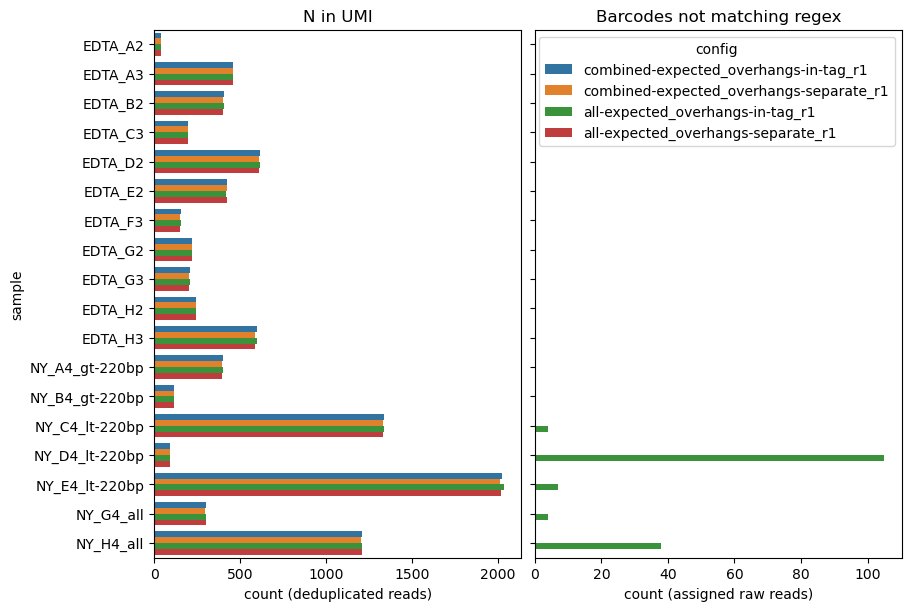

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(9, 6), constrained_layout=True, sharey=True)
sns.barplot(
    df_umi_val_all.loc[(df_umi_val_all['metric'] == 'N in UMI') & (df_umi_val_all['count_type'] == 'dedup')],
    x='count',
    y='sample',
    hue='config',
    ax=axs[0]
)
axs[0].set(title='N in UMI', xlabel='count (deduplicated reads)')
axs[0].get_legend().set_visible(False)
sns.barplot(
    df_umi_val_all.loc[df_umi_val_all['metric'] == 'n_unmatched'],
    x='count',
    y='sample',
    hue='config',
    ax=axs[1]
)
axs[1].set(title='Barcodes not matching regex', xlabel='count (assigned raw reads)', ylabel=None)
fig.show()

## Proportion of structures within a sample

In [32]:
df_structure_prop_all['config_short'] = df_structure_prop_all['config'].str.replace('-expected_', '; ').str.replace('_r1', '')
df_structure_prop_all['overhangs'] = df_structure_prop_all['config'].str.extract('overhangs-([^_]+)')
df_structure_prop_all['config_type'] = df_structure_prop_all['config'].str.extract('^([^-]+)')

In [33]:
# Grouped and stacked bar chart, adapted from 
# https://medium.com/@moritzkoerber/how-to-plot-a-grouped-stacked-bar-chart-in-plotly-df1685b83460
# Alternatively consider https://gist.github.com/ctokheim/6435202a1a880cfecd71

fig = go.Figure(
    layout=dict(
        template='simple_white',
        xaxis=dict(title_text='proportion of assigned, deduplicated reads', title_font_size=12),
        yaxis=dict(title_text='sample and config', title_font_size=12),
        barmode='stack',
        height=800,
        width=800,
        margin=dict(t=25, b=25, l=25, r=25),
        font_size=8,
        legend=dict(font_size=12, title_text='structure')
    )
)

colors = sns.color_palette(n_colors=len(STRUCTURES)).as_hex()

for structure, color in zip(STRUCTURES, colors):
    mask = (df_structure_prop_all['count_type'] == 'dedup') & \
           (df_structure_prop_all['structure'] == structure)
    fig.add_trace(go.Bar(
        x=df_structure_prop_all.loc[mask, 'prop'],
        y=[df_structure_prop_all.loc[mask, 'sample'], df_structure_prop_all.loc[mask, 'config_short']],
        name=structure,
        marker_color=color,
        orientation='h',
    ))

fig

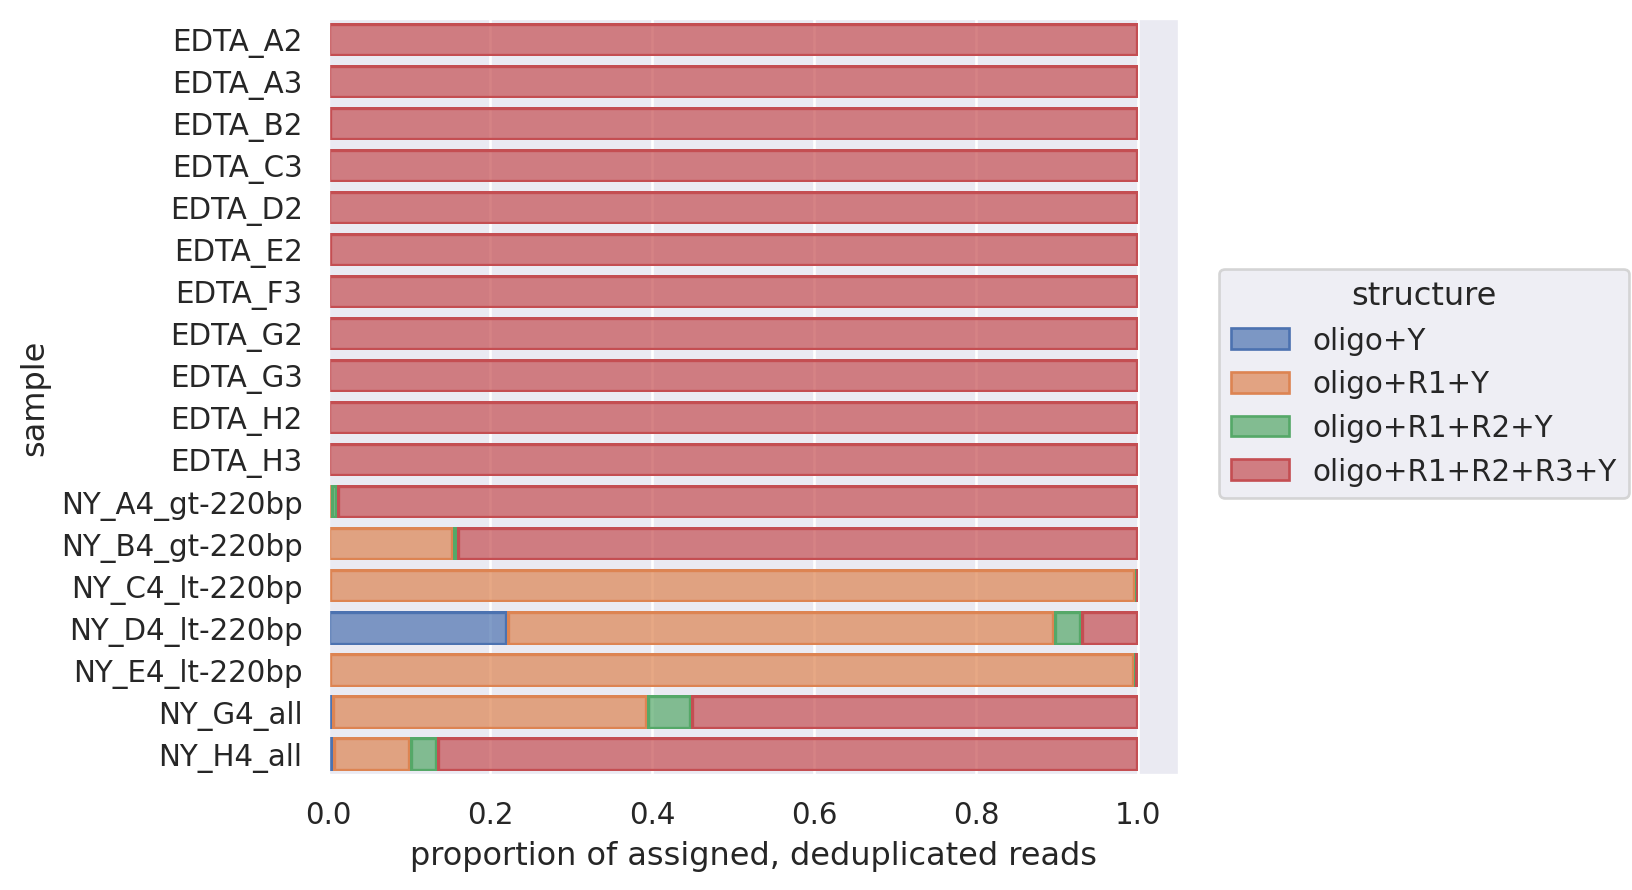

In [34]:
g = (
    so.Plot(
        (
            df_structure_prop_all
            .loc[
                (df_structure_prop_all['config_type'] == 'combined') & \
                (df_structure_prop_all['overhangs'] == 'separate') & \
                (df_structure_prop_all['count_type'] == 'dedup')
            ]
        ),
        y='sample',
        x='prop',
        color='structure')
    .add(so.Bar(), so.Stack())
    .label(x='proportion of assigned, deduplicated reads')
)
g.save(os.path.join(DIR_RESULTS, 'barcode_structure_proportion_dedup.png'), dpi=300, bbox_inches='tight')

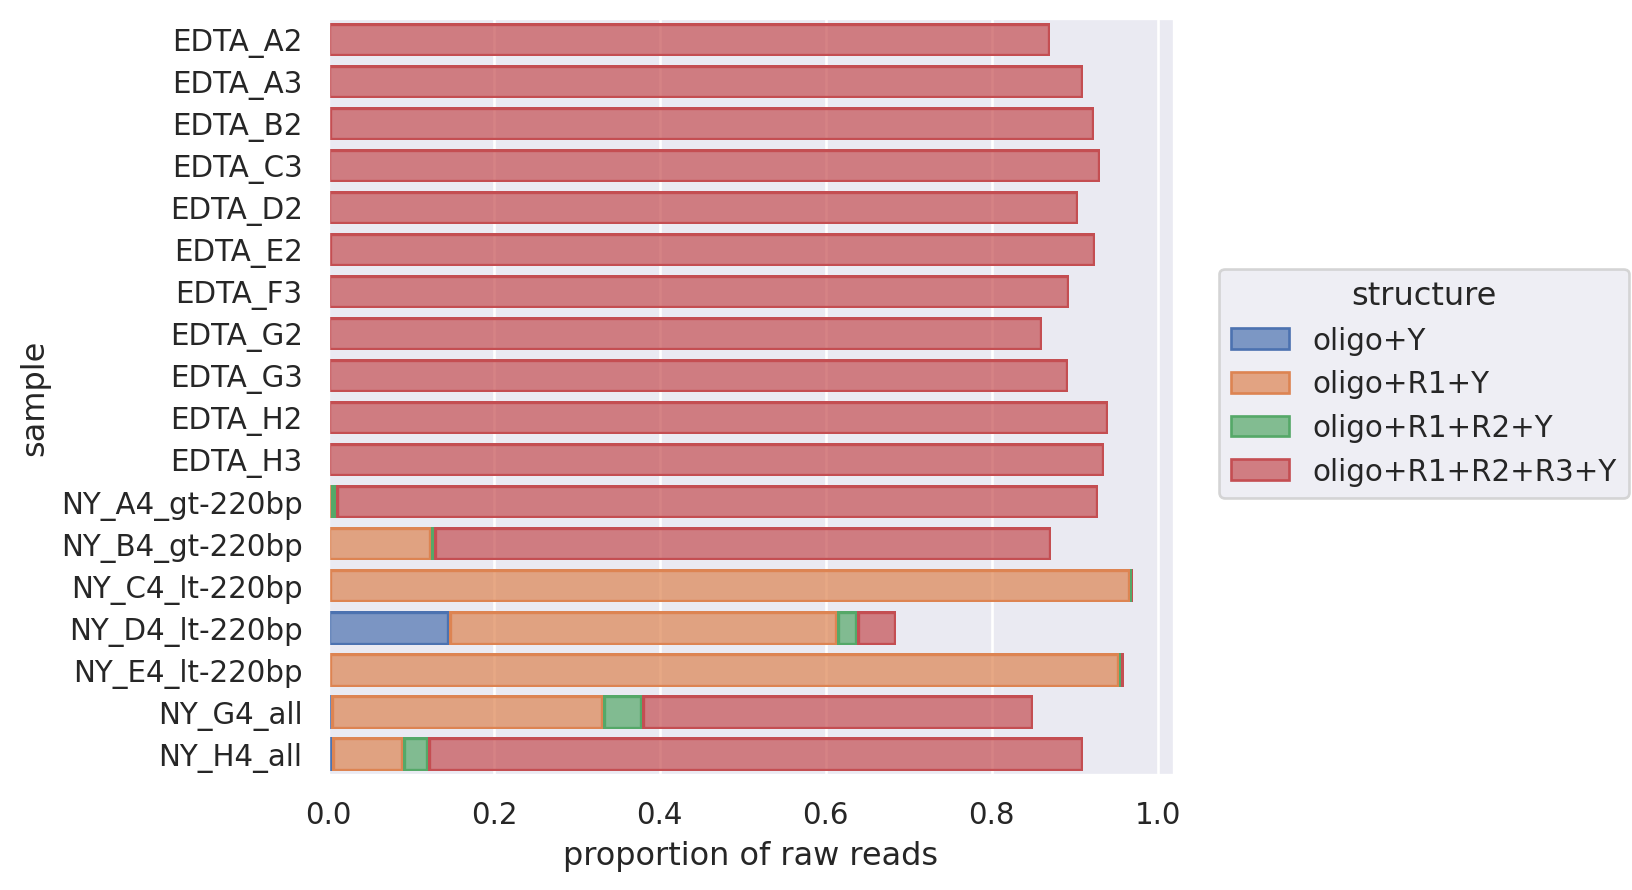

In [35]:
g = (
    so.Plot(
        (
            df_structure_prop_all
            .loc[
                (df_structure_prop_all['config_type'] == 'combined') & \
                (df_structure_prop_all['overhangs'] == 'separate') & \
                (df_structure_prop_all['count_type'] == 'raw')
            ]
        ),
        y='sample',
        x='prop',
        color='structure')
    .add(so.Bar(), so.Stack())
    .label(x='proportion of raw reads')
)
g.save(os.path.join(DIR_RESULTS, 'barcode_structure_proportion_raw.png'), dpi=300, bbox_inches='tight')

## Barcode counts

Compare individual config files vs. integrated config file

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



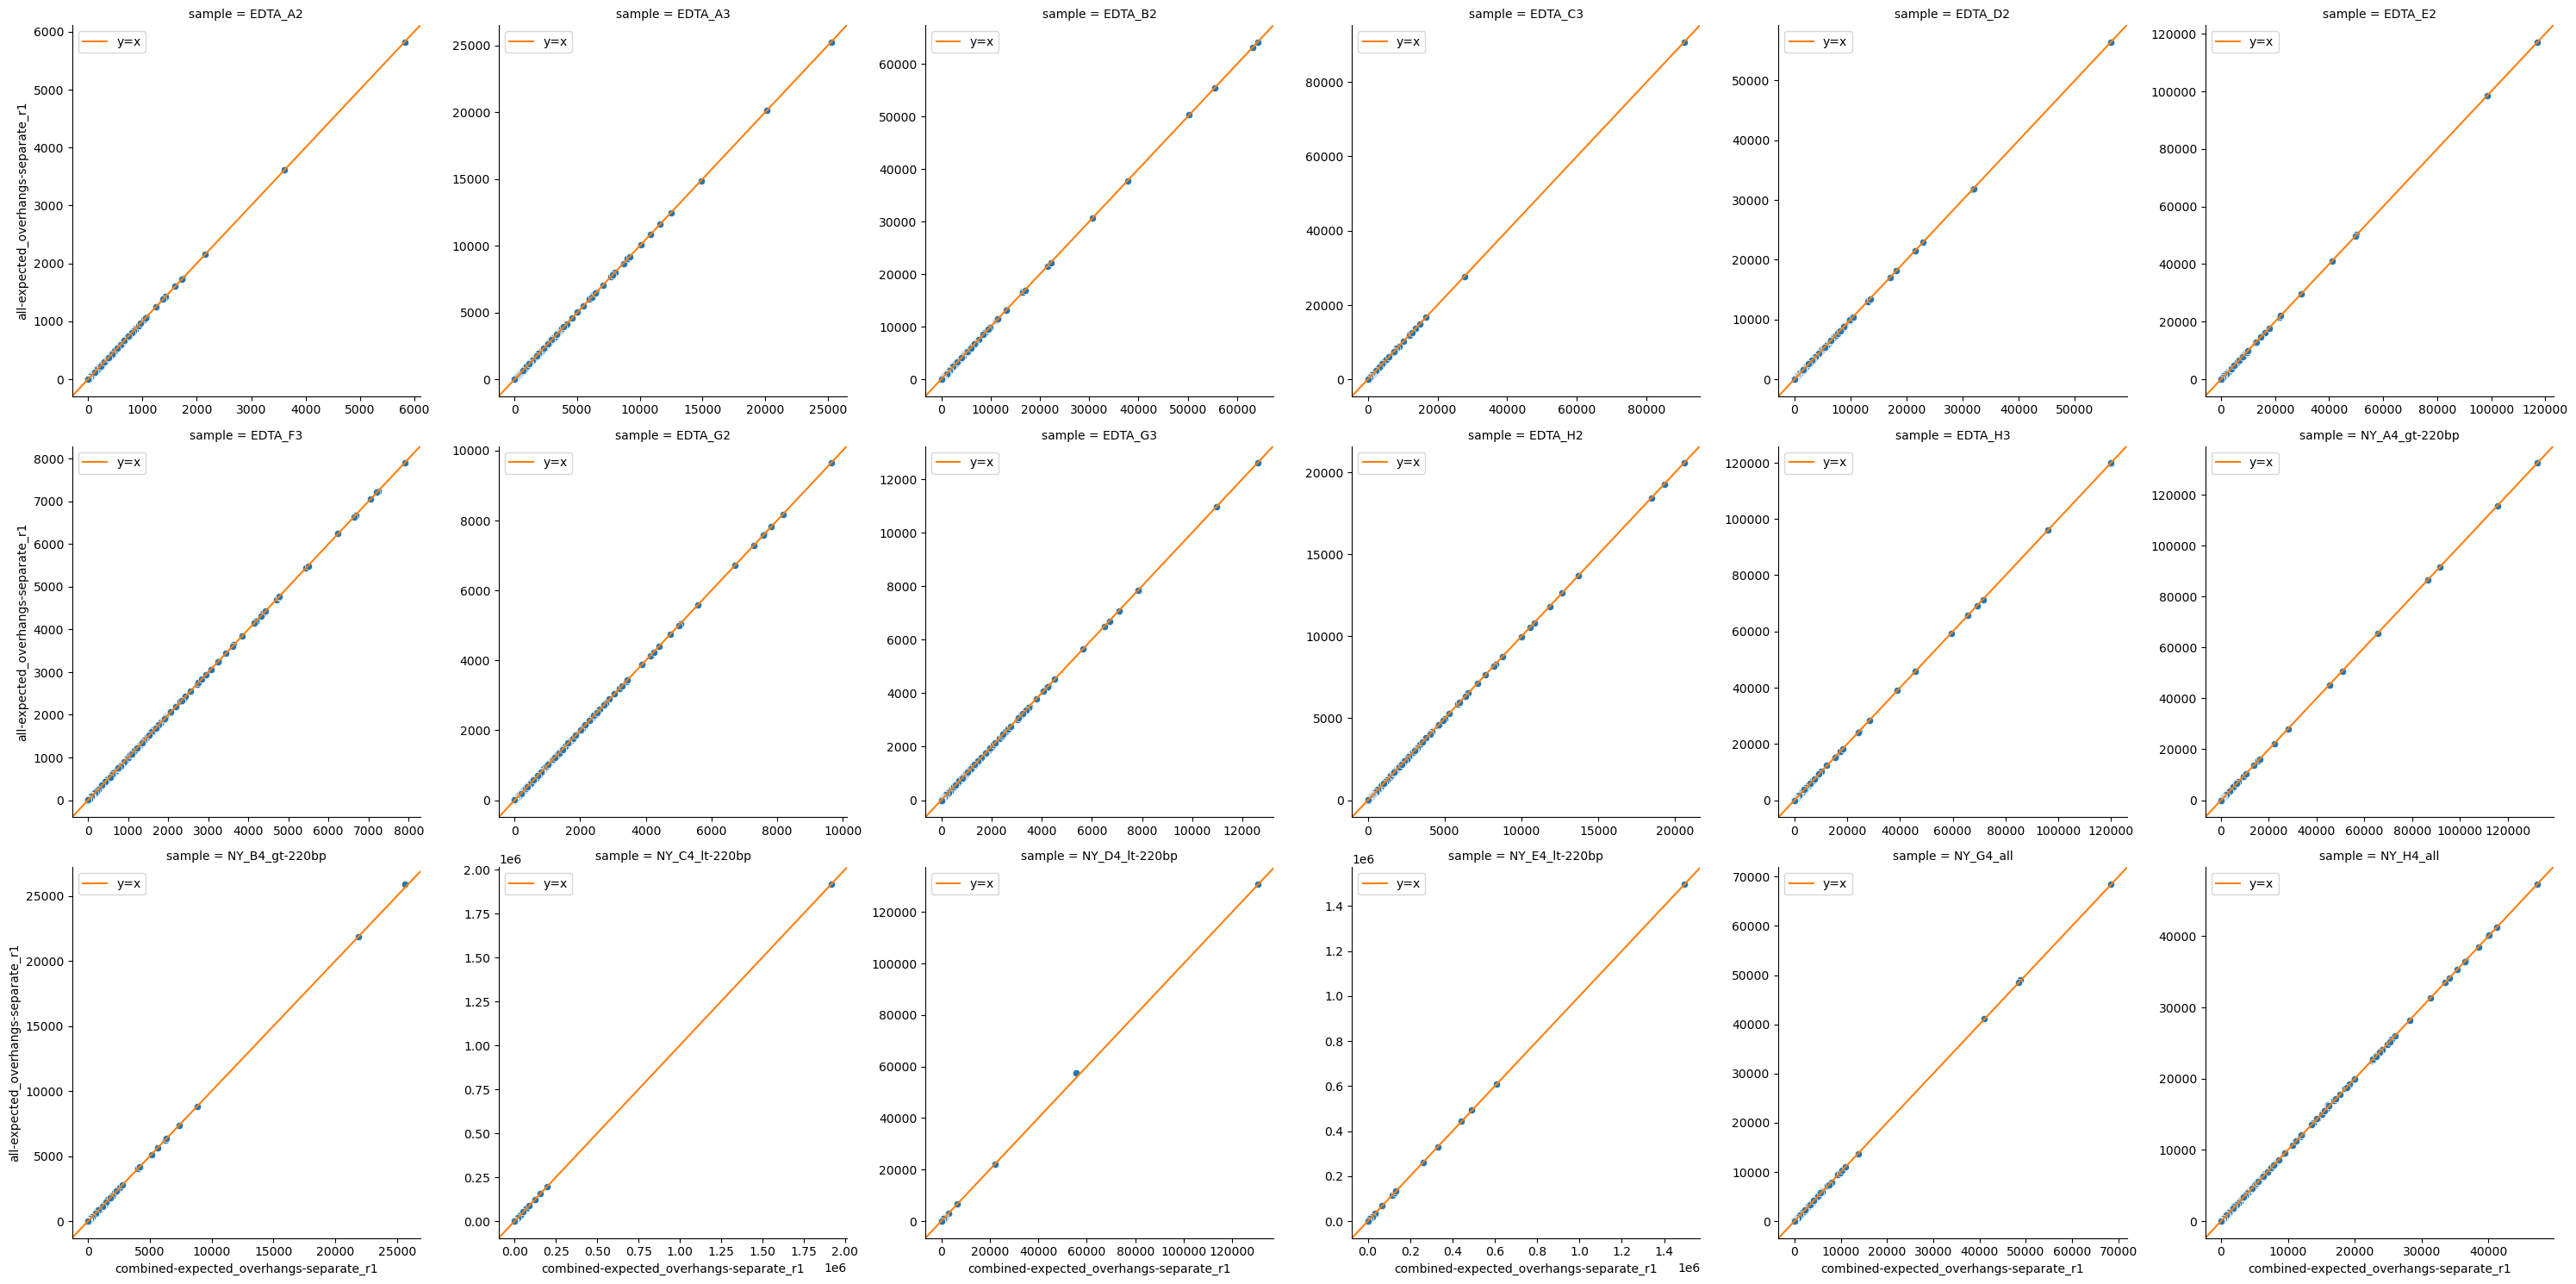

In [39]:
g = sns.relplot(
    kind='scatter',
    data=df_barcode_counts_all.loc[df_barcode_counts_all['count_type'] == 'dedup'],
    x='combined-expected_overhangs-separate_r1',
    y='all-expected_overhangs-separate_r1',
    col='sample',
    col_wrap=6,
    facet_kws=dict(sharex=False, sharey=False)
)
for ax in g.axes:
    ax.axline((0, 0), slope=1, color='C1', label='y=x')
    ax.legend()

Compare in-tag overhangs vs. separate overhangs

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



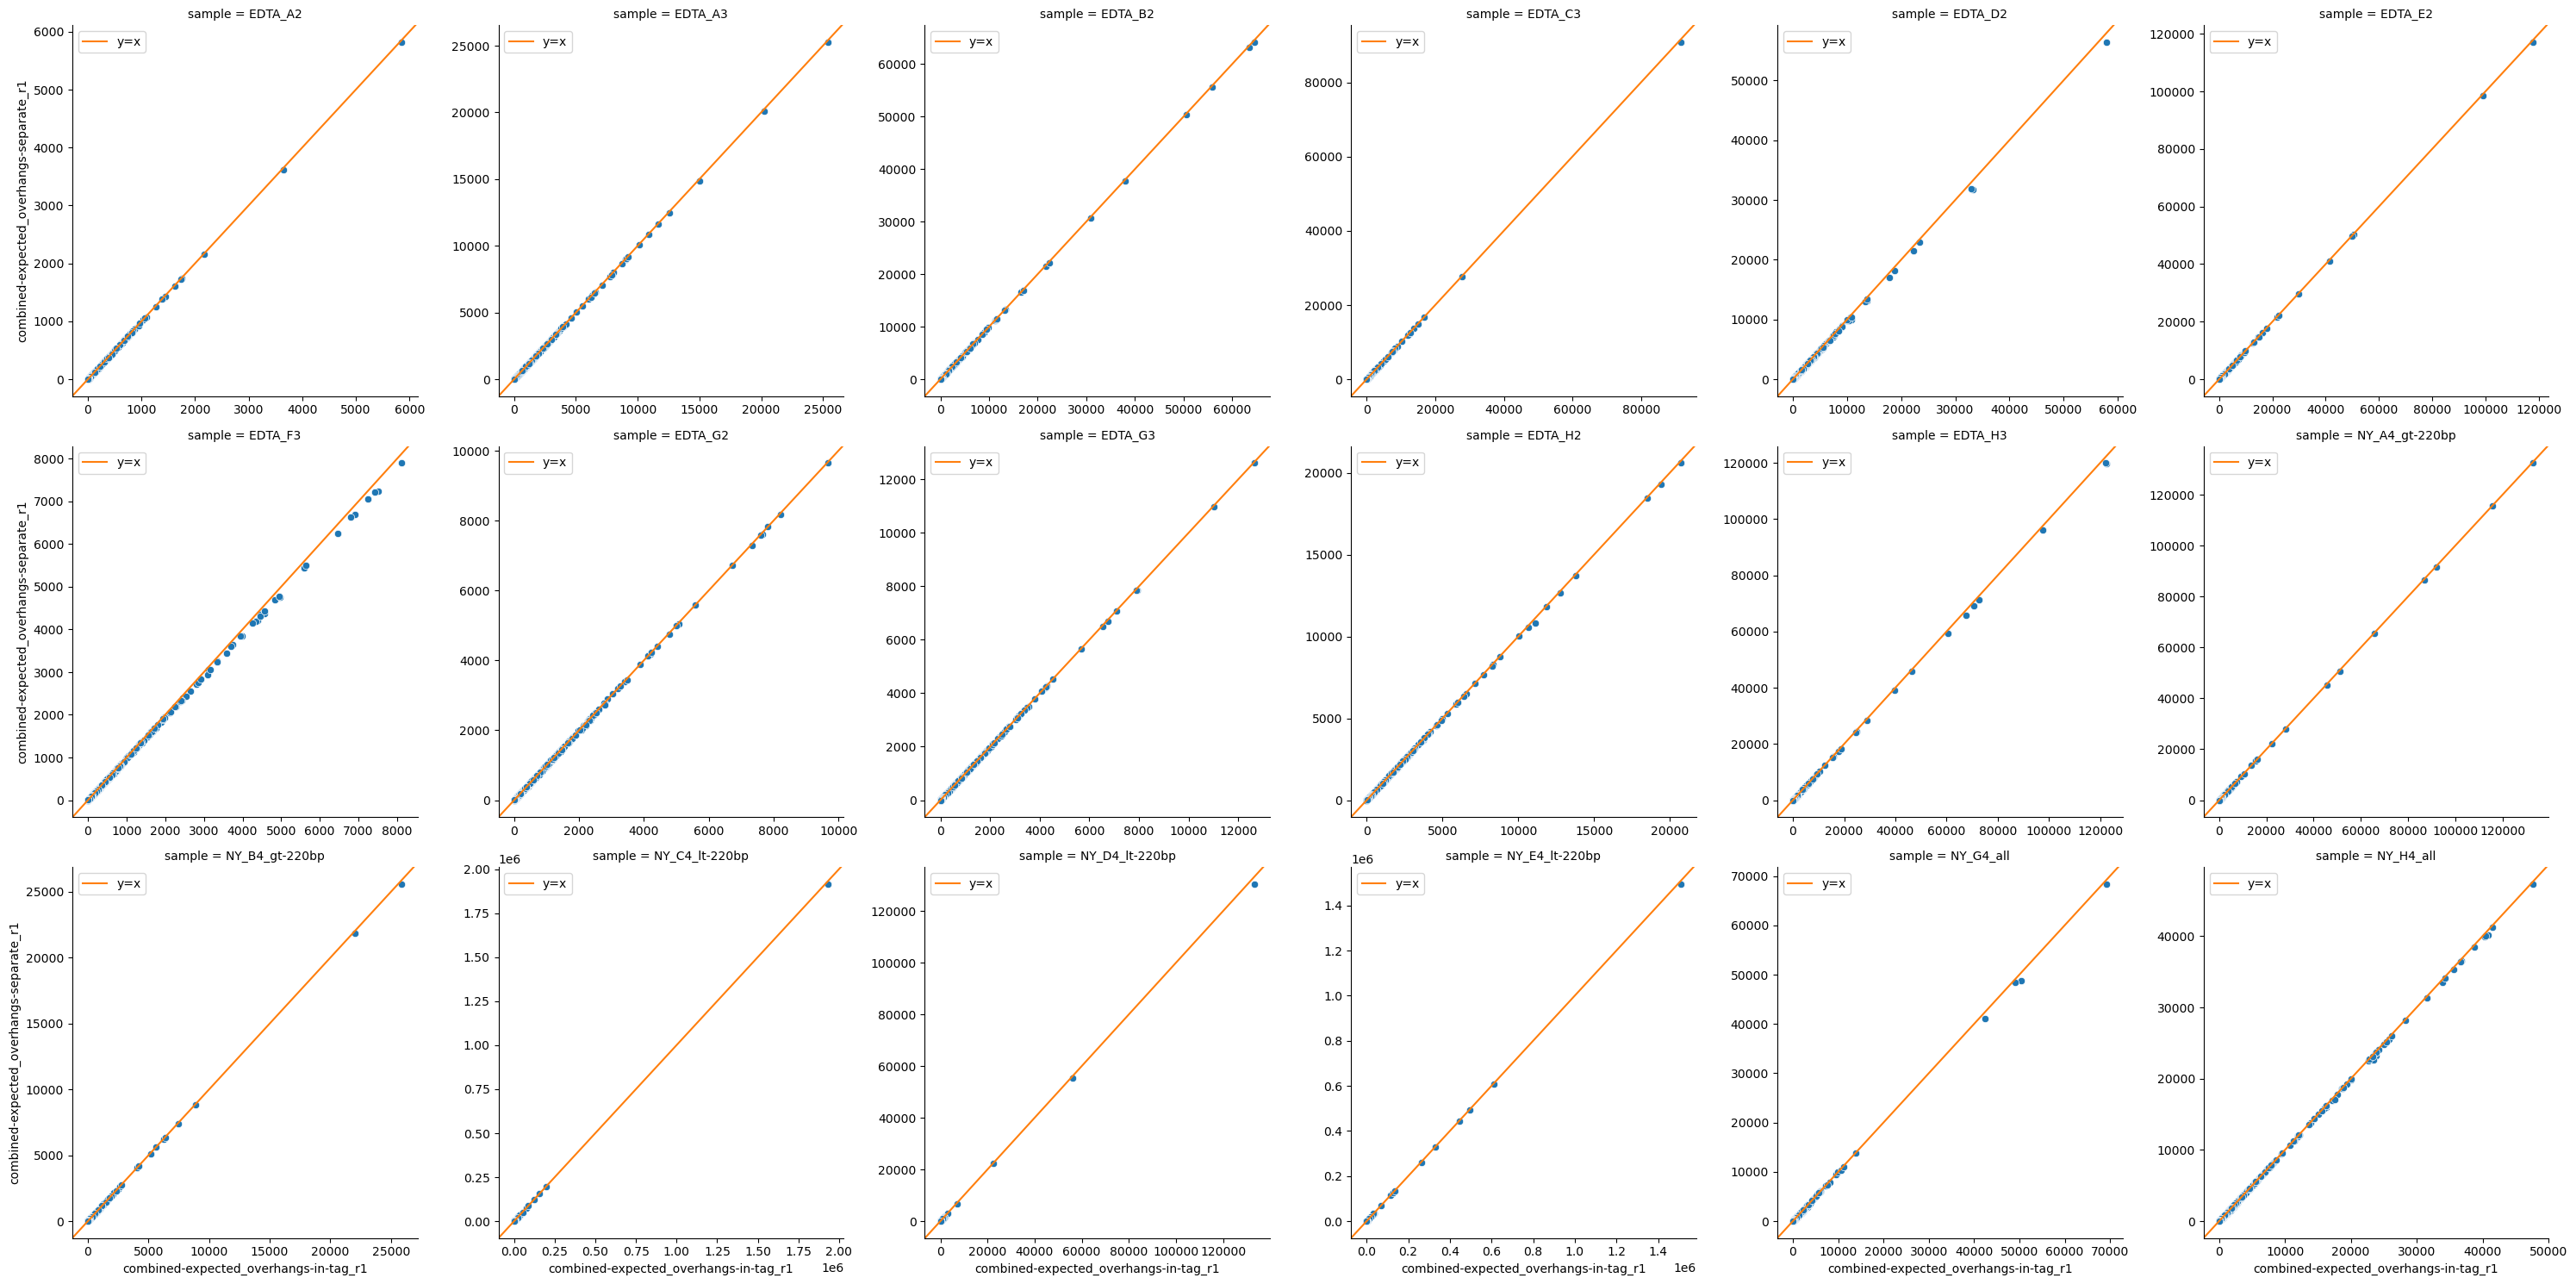

In [40]:
g = sns.relplot(
    kind='scatter',
    data=df_barcode_counts_all.loc[df_barcode_counts_all['count_type'] == 'dedup'],
    x='combined-expected_overhangs-in-tag_r1',
    y='combined-expected_overhangs-separate_r1',
    col='sample',
    col_wrap=6,
    facet_kws=dict(sharex=False, sharey=False)
)
for ax in g.axes:
    ax.axline((0, 0), slope=1, color='C1', label='y=x')
    ax.legend()

Compare terminal tag counts with `df_terminal_tags_r1_summary` generated earlier: concordant

In [41]:
(
    df_barcode_counts_all
    .loc[df_barcode_counts_all['count_type'] == 'dedup']
    .pipe(lambda df: df.assign(mode_overhang=df.apply(
        lambda row: 'LigEven' if row['R1'] == 0 else ('LigR1' if row['R2'] == 0 else ('LigR2' if row['R3'] == 0 else 'LigR3')),
        axis=1)))
    .groupby(['sample', 'mode_overhang', 'Y'], observed=True)
    .agg(count=('combined-expected_overhangs-separate_r1', 'sum'))
    .reset_index()
    .groupby('sample', group_keys=False)
    .apply(lambda df: df.sort_values('count', ascending=False).head(1))
    .drop(columns='count')
    .reset_index(drop=True)
    .rename(columns=dict(Y='mode_Y'))
    .merge(
        (
            df_terminal_tags_r1_summary[['sample', 'mode_Y-tag_Y', 'mode_Y-tag_overhang']]
            .rename(columns={
                'mode_Y-tag_Y': 'mode_Y',
                'mode_Y-tag_overhang': 'mode_overhang'})
        ),
        how='outer',
        indicator=True
    )
)

sample mode_overhang  mode_Y _merge
0          EDTA_A2         LigR3      16   both
1          EDTA_A3         LigR3      22   both
2          EDTA_B2         LigR3      11   both
3          EDTA_C3         LigR3      23   both
4          EDTA_D2         LigR3      20   both
5          EDTA_E2         LigR3      21   both
6          EDTA_F3         LigR3      15   both
7          EDTA_G2         LigR3      14   both
8          EDTA_G3         LigR3      23   both
9          EDTA_H2         LigR3      13   both
10         EDTA_H3         LigR3       6   both
11  NY_A4_gt-220bp         LigR3      23   both
12  NY_B4_gt-220bp         LigR3       1   both
13  NY_C4_lt-220bp         LigR1       1   both
14  NY_D4_lt-220bp         LigR1       1   both
15  NY_E4_lt-220bp         LigR1       1   both
16       NY_G4_all         LigR3       7   both
17       NY_H4_all         LigR3      13   both

# Ligation QC

| Round    | Tags used (wells) | Tags used (ID) | Tags added during pooling | Pooling orientation     |
| -------- | ----------------- | -------------- | ------------------------- | ----------------------- |
| R1       | A1-A11, B1-B11    | 1-11, 13-23    | A12 (12), B12 (24)        | 12 apart                |
| R2       | C1-C11, D1-D11    | 1-11, 13-23    | C12 (12), D12 (24)        | 12 apart                |
| R3       | E1-E11, F1-F11    | 1-11, 13-23    | E12 (12), F12 (24)        | 12 apart                |
| Y        | A1-A11, B1-B11    | 1-11, 13-23    | A12 (12), B12 (24)        | 12 apart                |

Exceptions:
- Terminal quench, round R1: pool-only tags = B11 (23), B12 (24)
- EDTA quench, round R2: pool-only tags = D11 (23), D12 (24)

In [42]:
pooled_tags = {}
for r in ROUNDS:
    for sample in df_data['basename'].unique():
        if (r == 'R1' and sample.startswith('NY')) or (r == 'R2' and sample.startswith('EDTA')):
            pooled_tags[(r, sample)] = [23, 24]
        else:
            pooled_tags[(r, sample)] = [12, 24]

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



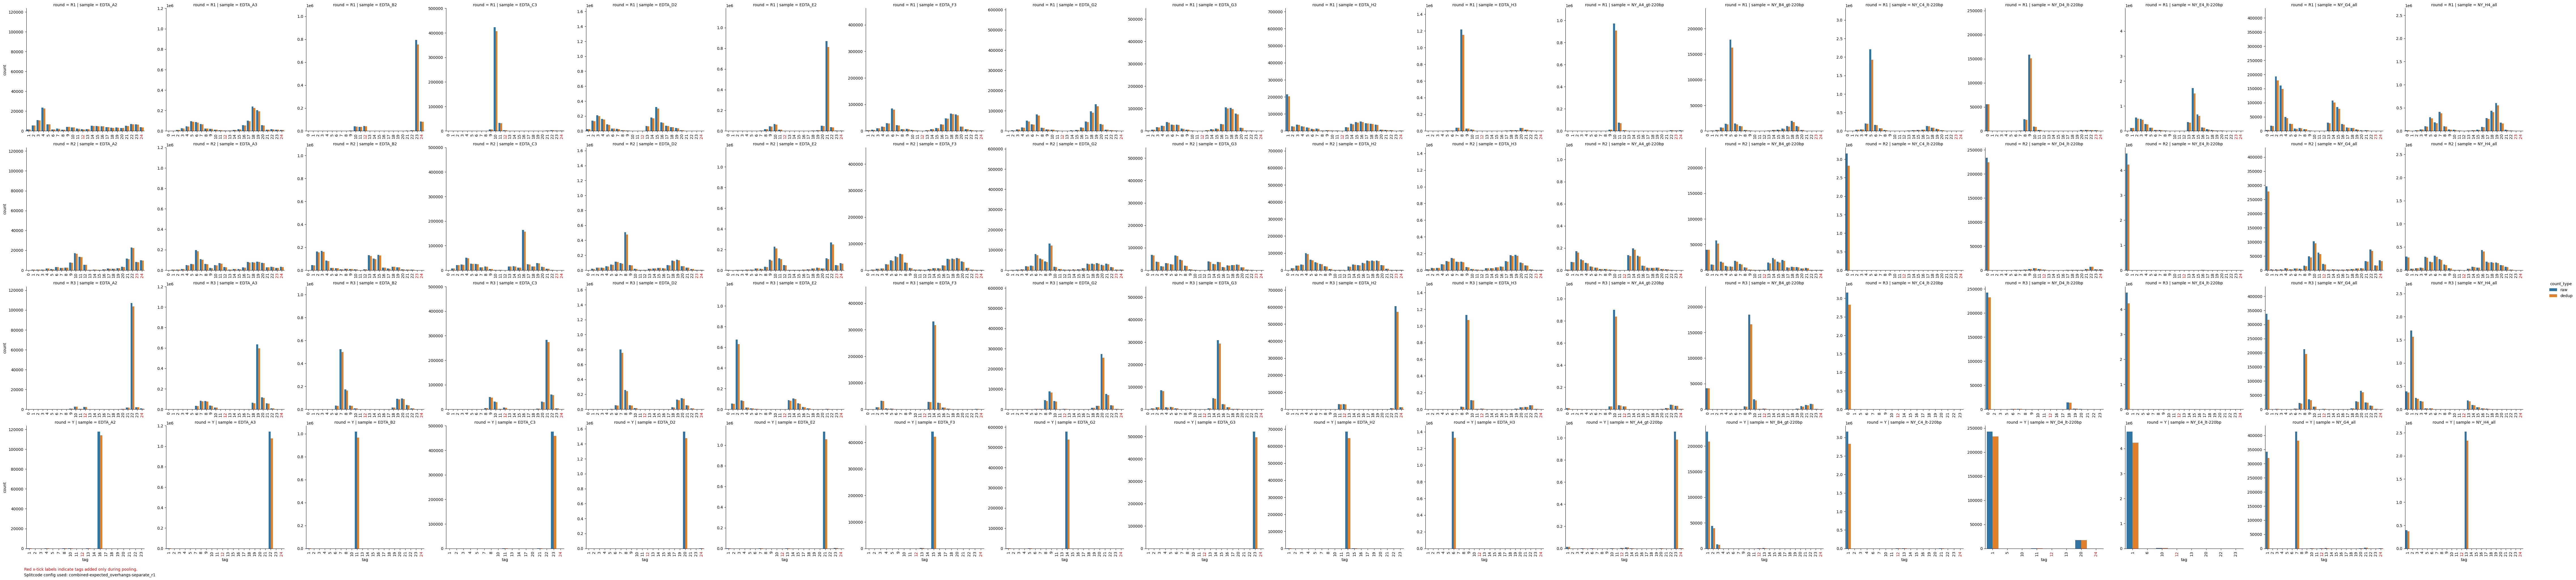

In [43]:
g = sns.catplot(
    df_tag_counts.loc[(df_tag_counts['config'] == 'combined-expected_overhangs-separate_r1')],
    kind='bar',
    x='tag',
    y='count',
    row='round',
    row_order=ROUNDS,
    hue='count_type',
    col='sample',
    sharex=False,
    sharey='col'
)

# red color for xticklabels corresponding to tags added during pooling
for (r, sample), ax in g.axes_dict.items():
    for text in ax.get_xticklabels():
        if int(text.get_text()) in pooled_tags[(r, sample)]:
            text.set_color('red')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

g.figure.text(
    0.01,
    -0.01,
    'Red x-tick labels indicate tags added only during pooling.',
    color='red',
    ha='left'
)

g.figure.text(
    0.01,
    -0.02,
    'Splitcode config used: combined-expected_overhangs-separate_r1',
    ha='left'
)

g.figure.savefig(
    os.path.join(DIR_RESULTS, 'tag_counts_by_sample.pdf'),
    bbox_inches='tight',
    dpi=300
)

Flow diagram (Sankey / parallel categories plot)

In [44]:
mask_dedup = (df_barcode_counts_all['count_type'] == 'dedup')
config = 'combined-expected_overhangs-separate_r1'
for sample in df_barcode_counts_all['sample'].unique():
    mask_sample = (df_barcode_counts_all['sample'] == sample)
    fig = go.Figure(go.Parcats(
        dimensions=[
            {
                'label': r,
                'values': df_barcode_counts_all.loc[mask_dedup & mask_sample, r]
            } for r in ROUNDS
        ],
        counts=df_barcode_counts_all.loc[mask_dedup & mask_sample, config]))
    fig.update_layout(
        title_text=f'Sample: {sample}',
        width=600,
        height=600,
        margin=dict(l=10, b=10, t=50, r=10)
    )
    # fig.show()
    fig.write_image(os.path.join(DIR_RESULTS, f'parcats_{sample}.pdf'))

Count (or proportion of total count) per barcode (akin to scSPRITE Figure 1C)

In [121]:
fig = px.line(
    (
        df_barcode_counts_all
        .loc[df_barcode_counts_all['count_type'] == 'dedup']
        [ROUNDS + ['sample', 'combined-expected_overhangs-separate_r1']]
        .rename(columns={'combined-expected_overhangs-separate_r1': 'count'})
        .groupby('sample')
        .apply(lambda g:
           g.assign(
               rank=np.argsort(np.argsort(-g['count'])),
               proportion=g['count'] / g['count'].sum(),
               quench=g['sample'].str.extract('^(EDTA|NY)')
           ).pipe(lambda g2: g2.loc[g2['rank'] < 10]))
        .melt(id_vars=['sample', 'quench', 'rank'], value_vars=['count', 'proportion'], var_name='metric')
        .sort_values(['sample', 'rank'])
    ),
    x='rank',
    y='value',
    color='sample',
    facet_col='quench',
    facet_row='metric',
    markers=True,
    category_orders=dict(sample=sorted(df_data['basename'].unique())),
    color_discrete_sequence=sns.color_palette('tab20', n_colors=len(df_data['basename'].unique())).as_hex(),
    labels={'rank': 'barcode rank'}
)
fig.update_yaxes(matches=None)
fig.update_layout(
    margin=dict(l=0, b=10, t=50, r=10),
    height=600,
    width=800
)
fig.write_image(os.path.join(DIR_RESULTS, 'barcode_count_by_barcode_rank.png'), scale=2)
fig.show()

# Sequencing Depth and Duplicates

## UMI distribution

In [45]:
umi_distribution = (
    pd.concat((pd.concat((pd.Series(0), s)) for s in df_umi_ecdf.values()), axis=1)
    .fillna(0)
    .sort_index()
    .sum(axis=1)
    .pipe(lambda s: s/s.sum())
    .to_frame(name='prop')
    .reset_index(names='count')
)
display(umi_distribution)
print('mean UMI count: {:.3f}'.format((umi_distribution['count'] * umi_distribution['prop']).sum()))

count          prop
0      0  0.000000e+00
1      1  9.258893e-01
2      2  6.841553e-02
3      3  5.146808e-03
4      4  4.812616e-04
5      5  5.553203e-05
6      6  9.636795e-06
7      7  1.638255e-06
8      8  2.650119e-07
9     10  4.818398e-08

mean UMI count: 1.080


In [46]:
df_umi_ecdf_long = (
    pd.concat((pd.concat((pd.Series(0), s)) for s in df_umi_ecdf.values()), axis=1)
    .fillna(0)
    .sort_index()
    .cumsum(axis=0)
    .apply(lambda x: x/x.max(), axis=0)
    .reset_index(names='count')
    .melt(id_vars=['count'], var_name='sample-config', value_name='cumulative_prop')
    .pipe(lambda df: 
          df.assign(
              sample=df['sample-config'].map(lambda i: list(df_umi_ecdf.keys())[i][0]),
              config=df['sample-config'].map(lambda i: list(df_umi_ecdf.keys())[i][1])
          )
    )
)

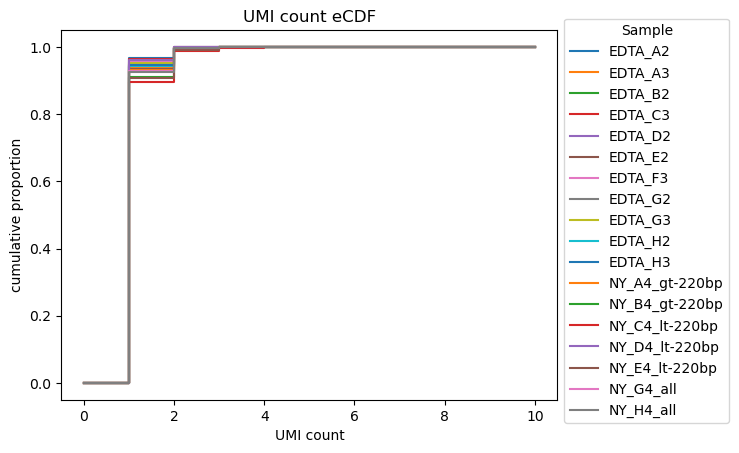

In [50]:
fig, ax = plt.subplots()
mask_config = df_umi_ecdf_long['config'] == 'combined-expected_overhangs-separate_r1'
for sample in sorted(df_umi_ecdf_long['sample'].unique()):
    mask = mask_config & (df_umi_ecdf_long['sample'] == sample)
    ax.step(
        df_umi_ecdf_long.loc[mask, 'count'],
        df_umi_ecdf_long.loc[mask, 'cumulative_prop'],
        where='post',
        label=sample
    )
ax.legend(title='Sample', loc='upper left', bbox_to_anchor=(1, 1.05))
ax.set(xlabel='UMI count', ylabel='cumulative proportion', title='UMI count eCDF')
fig.show()

## Estimate library complexity

Note: The current method of library complexity estimation assumes that the number of available UMIs far exceeds the number of unique molecules, and therefore underestimates the true library complexity. A better model would account for the possibility of real UMI collisions, and as a consequence of PCR duplicates/sequencing.

In [51]:
def estimate_library_complexity(count_total, count_dedup, max_err=1e-3):
    '''
    See https://github.com/bentyeh/resources/blob/main/bioinformatics/models_genomics.md

    Generative model: Poisson sampling (i.e., with replacement) count_total reads from
    M unique molecules, such that count_dedup molecules were sampled at least once. Solve
    for M.
    '''
    res = scipy.optimize.minimize_scalar(
      fun=lambda M: (M * (1 - np.exp(-count_total/M)) - count_dedup)**2,
      bracket=(count_dedup, count_total*2)
    )
    assert res.fun < max_err
    return res.x

In [52]:
umi_complexity = 4**12
print('Maximum UMI complexity:', umi_complexity)

Maximum UMI complexity: 16777216


Calculate the complexity of all barcodes in each sample.

In [53]:
complexity_umi_all = (
    df_barcode_counts_all
    .groupby(['sample', 'count_type'])
    ['combined-expected_overhangs-separate_r1'].sum()
    .reset_index()
    .rename(columns={'combined-expected_overhangs-separate_r1': 'count'})
    .pivot(columns='count_type', index='sample', values='count')
    .apply(lambda s: estimate_library_complexity(s['raw'], s['dedup']), axis=1)
)

Calculate the complexity of the predominant barcode in each sample.

In [54]:
complexity_umi_top = (
    df_barcode_counts_all
    [ROUNDS + ['sample', 'count_type', 'combined-expected_overhangs-separate_r1']]
    .rename(columns={'combined-expected_overhangs-separate_r1': 'count'})
    .pivot(columns='count_type', index=ROUNDS + ['sample'], values='count')
    .reset_index()
    .groupby('sample', group_keys=True)
    .apply(lambda group: group.iloc[group['dedup'].argmax()][['raw', 'dedup']])
    .apply(lambda s: estimate_library_complexity(s['raw'], s['dedup']), axis=1)
)

### Plot

Complexity estimated by Tapestation is within ~2-fold of complexity estimated by sequencing.

In [63]:
df_data = df_data.merge(
    pd.concat(
        (
            complexity_umi_top.rename('complexity_umi_est_top'),
            complexity_umi_all.rename('complexity_umi_est_all'),
            pd.Series(
                {k[0]: s.sum() for k, s in df_umi_ecdf.items() if k[1] == 'combined-expected_overhangs-separate_r1'},
                name='complexity_obs'
            ),
            (
                df_barcode_counts_all
                .loc[df_barcode_counts_all['count_type'] == 'raw']
                .groupby('sample')
                ['combined-expected_overhangs-separate_r1'].sum()
                .rename('n_assigned')
            )
        ),
        axis=1,
    ).reset_index(names='basename'),
    how='left',
    on='basename'
)

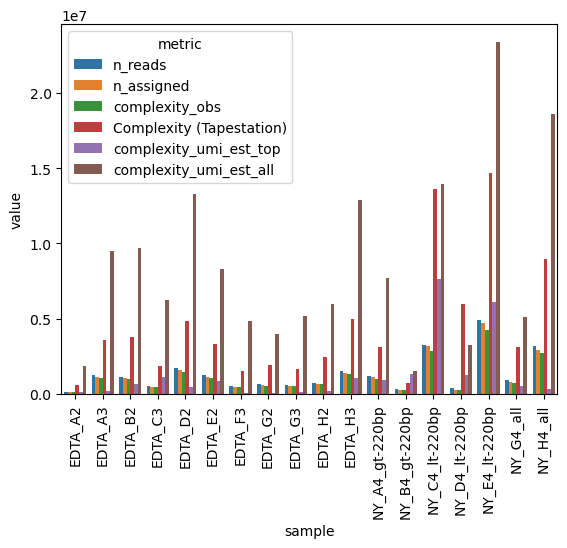

In [69]:
ax = sns.barplot(
    (
        df_data
        [['basename', 'n_reads', 'n_assigned', 'complexity_obs', 'Complexity (Tapestation)', 'complexity_umi_est_top', 'complexity_umi_est_all']]
        .drop_duplicates()
        .melt(id_vars='basename')
        .rename(columns={'basename': 'sample', 'variable': 'metric'})
    ),
    x='sample',
    y='value',
    hue='metric'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.figure.show()

## Estimated coverage and duplication rate

"Coverage" = proportion of physical molecules that were sequenced and assigned.
- Assume sampling `n_assigned` reads from `Complexity (Tapestation)` molecules.

In [71]:
df_data[['basename', 'n_assigned', 'Complexity (Tapestation)']].drop_duplicates() \
    .set_index('basename')\
    .apply(
        lambda s: 1 - scipy.stats.binom.pmf(0, n=s['n_assigned'], p=1/s['Complexity (Tapestation)']),
        axis=1) \
    .rename('coverage')

basename
EDTA_A2           0.181626
EDTA_A3           0.274271
EDTA_B2           0.237204
EDTA_C3           0.225393
EDTA_D2           0.276736
EDTA_E2           0.289840
EDTA_F3           0.250963
EDTA_G2           0.257107
EDTA_G3           0.273889
EDTA_H2           0.246234
EDTA_H3           0.244576
NY_A4_gt-220bp    0.293891
NY_B4_gt-220bp    0.328494
NY_C4_lt-220bp    0.207736
NY_D4_lt-220bp    0.042922
NY_E4_lt-220bp    0.273392
NY_G4_all         0.215133
NY_H4_all         0.279259
Name: coverage, dtype: float64

Duplication rate = proportion of sequenced and assigned reads that are duplicates

In [78]:
(
    df_barcode_counts_all
    .groupby(['sample', 'count_type'])
    ['combined-expected_overhangs-separate_r1'].sum()
    .reset_index(name='count')
    .pivot(columns='count_type', index='sample', values='count')
    .pipe(lambda df: df.assign(**{'duplication rate': (df['raw'] - df['dedup'])/df['raw']}))
)

count_type          raw    dedup  duplication rate
sample                                            
EDTA_A2          118257   114546          0.031381
EDTA_A3         1144464  1078075          0.058009
EDTA_B2         1020785   968737          0.050988
EDTA_C3          477598   459734          0.037404
EDTA_D2         1564828  1476130          0.056682
EDTA_E2         1139743  1064740          0.065807
EDTA_F3          442119   422552          0.044257
EDTA_G2          579546   539425          0.069228
EDTA_G3          521686   496198          0.048857
EDTA_H2          686896   648792          0.055473
EDTA_H3         1402378  1328612          0.052601
NY_A4_gt-220bp  1092677  1018901          0.067519
NY_B4_gt-220bp   281152   256432          0.087924
NY_C4_lt-220bp  3166902  2833686          0.105218
NY_D4_lt-220bp   260593   250495          0.038750
NY_E4_lt-220bp  4694713  4253640          0.093951
NY_G4_all        760637   706729          0.070872
NY_H4_all       2924361  2705786          0.074743

# Old

### Proportion of reads matching each expected structure

Proportion of reads from each sample that were properly barcoded (considered "assigned" by splitcode)

In [216]:
for sc_config in splitcode_configs:
    df_data[f'n_assigned-{sc_config}'] = 0
    for sample in df_data['basename'].unique():
        mask_sample = df_data['basename'] == sample
        n_reads = df_data.loc[mask_sample, 'n_reads'].iloc[0]
        path_summary = os.path.join(DIR_PROC, f'summary-{sc_config}-{sample}.json')
        with open(path_summary, 'rt') as f:
            summary = json.load(f)
        assert summary['n_processed'] == n_reads
        # check that all assigned reads had UMIs of length 12
        if summary['n_assigned'] > 0:
            assert summary['extraction_info'][0]['n_reads'] == summary['n_assigned']
            assert summary['extraction_info'][0]['length_min'] == summary['extraction_info'][0]['length_min'] == 12
        df_data.loc[mask_sample, f'n_assigned-{sc_config}'] = summary['n_assigned']

In [211]:
df_prop_assigned = (
    df_data
    [['basename', 'n_reads'] + [x for x in df_data.columns if x.startswith('n_assigned')]]
    .drop_duplicates()
    .pipe(lambda df: df.assign(**{
        f'prop_assigned-{sc_config}': df[f'n_assigned-{sc_config}'] / df['n_reads']
        for sc_config in splitcode_configs
    }))
    .pipe(lambda df: df[[x for x in df.columns if x.startswith('prop_assigned')] + ['basename']])
    .melt(id_vars='basename', var_name='config', value_name='proportion_assigned')
)
df_prop_assigned['structure'] = df_prop_assigned['config'].str.extract('(oligo+[^_]+)')
df_prop_assigned['overhangs'] = df_prop_assigned['config'].str.extract('overhangs-(separate|in-tag)')

In [212]:
# compare overhangs-in-tag vs. overhangs-separate
fig = px.scatter(
    (
        df_prop_assigned
        .drop(columns='config')
        .pivot(index=['basename', 'structure'], values='proportion_assigned', columns='overhangs')
        .reset_index()
    ),
    x='separate',
    y='in-tag',
    color='basename',
    facet_col='structure',
    facet_col_wrap=2
)

fig.update_layout(height=450, margin=dict(l=10, r=10, b=10, t=20))
fig.update_yaxes(matches=None, showticklabels=True)
fig.update_xaxes(matches=None, showticklabels=True)
fig.show()

# # Alternative non-interactive plot using seaborn
# g = sns.relplot(
#     kind='scatter',
#     data=(
#         df_prop_assigned
#         .drop(columns='config')
#         .pivot(index=['basename', 'structure'], values='proportion_assigned', columns='overhangs')
#         .reset_index()
#     ),
#     x='separate',
#     y='in-tag',
#     col='structure',
#     hue='basename',
#     col_wrap=2,
#     facet_kws=dict(sharex=False, sharey=False)
# )

Proportion of (non-deduplicated) reads matching each structure

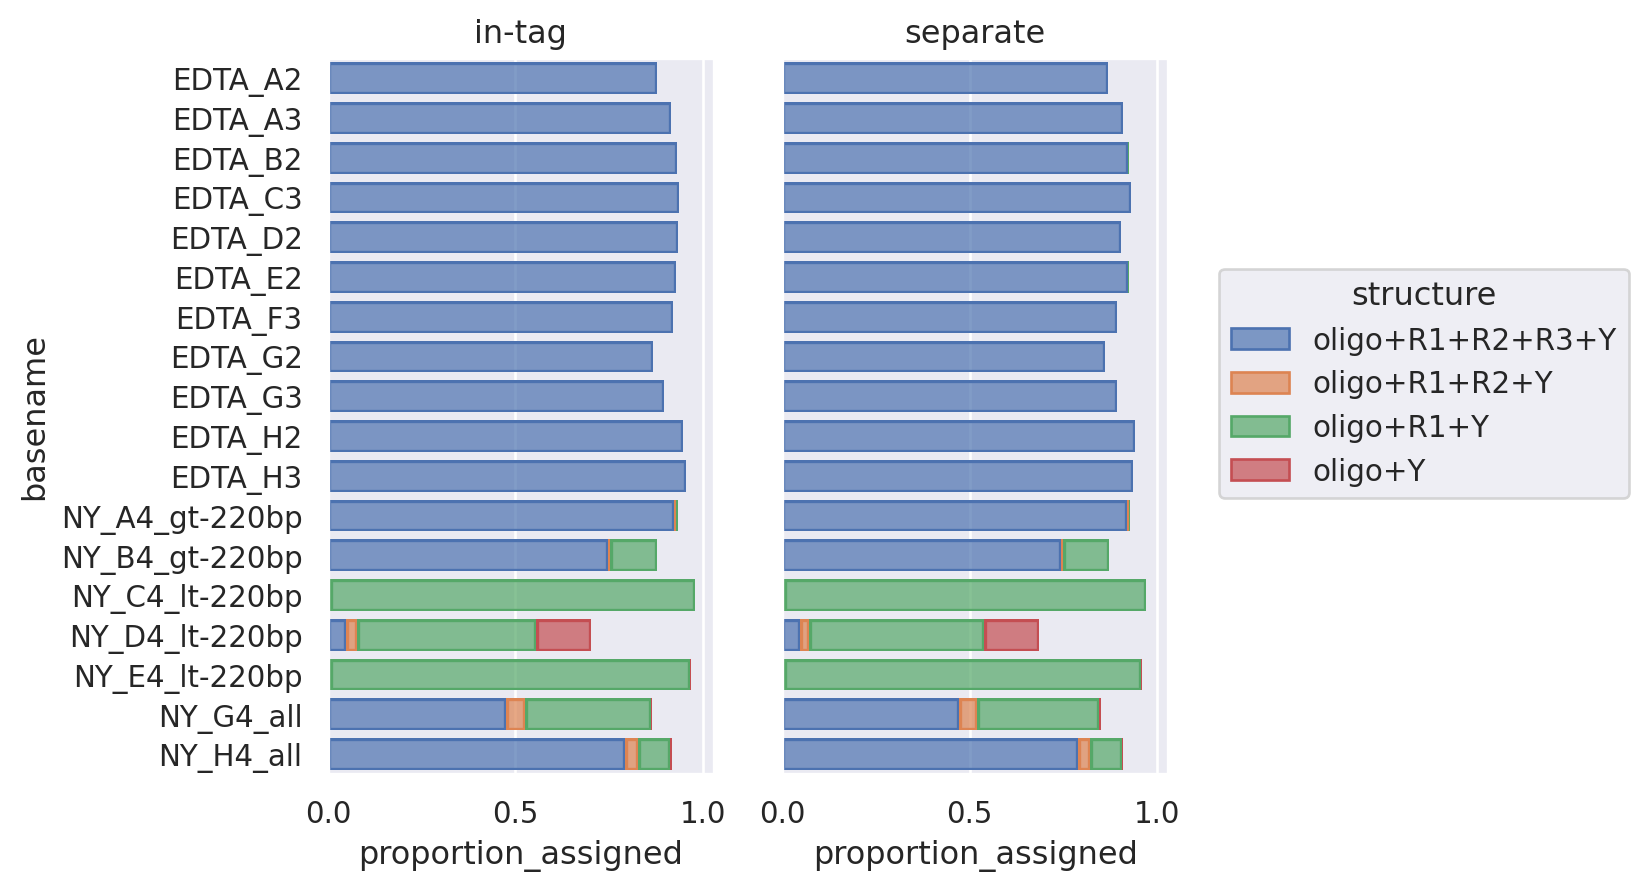

In [213]:
(
    so.Plot(df_prop_assigned, y='basename', x='proportion_assigned', color='structure')
    .add(so.Bar(), so.Stack())
    .facet('overhangs')
)

## Parse barcode counts to DataFrames

- `df_umi_counts`: closest representation of raw data; counts per [[barcode + UMI]]
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `umi`
  - `value_vars`: `count`
- `df_barcode_counts`: counts (both undeduplicated and deduplicated by UMI) per [[barcode]]
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`
  - `value_vars`: `count`, `count_dedup`
- `df_tag_counts`: counts per [[tag]]
  - format: long
  - `id_vars`: `sample`, `round`, `tag`, `deduplication`
  - `value_vars`: `count`

Final analysis, for each sample, for each structure:
- Deduplicated count
- Estimation of library complexity (at the level of sample-structure, and at the level of sample)
- Sankey/Parcats plots
  - Incorporate "NY" tag: remaining tags become "NA"

In [ ]:
df_barcode_counts_all = []
for sample in df_data['basename'].unique():
    for sc_config in ('all-expected_overhangs-in-tag_r1', 'all-expected_overhangs-separate_r1'):
        path_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{sc_config}-{sample}.txt.gz')
        with gzip.open(path_barcodes, 'rt') as f:
            df_umi_counts, n_unmatched, unmatched = parse_barcodes.barcodes_to_df(
                f,
                regex_barcode_overhangs_separate if 'separate' in sc_config else regex_barcode_overhangs_in_tag)
            df_umi_counts = (
                df_umi_counts
                .fillna(0)
                .astype(dict(R1=np.uint8, R2=np.uint8, R3=np.uint8, Y=np.uint8))
                .groupby(list(df_umi_counts.columns), observed=True).size()
                .reset_index().rename(columns={0: 'count'})
            )
            assert np.array_equal(df_umi_counts['umi'].map(len).unique(), np.array([12]))
            df_barcode_counts = (
                df_umi_counts
                .loc[~df_umi_counts['umi'].str.contains('N')]
                .groupby(ROUNDS, observed=True)["count"]
                .agg(["count", "sum"])
                .reset_index()
                .rename(columns={"count": "count_dedup", "sum": "count"})
            )
            df_barcode_counts['sample'] = pd.Series([sample] * len(df_barcode_counts), dtype=dtype_sample)
            df_barcode_counts['config'] = pd.Series([sc_config] * len(df_barcode_counts), dtype=dtype_sc_config)
            df_barcode_counts_all.append(df_barcode_counts)
df_barcode_counts_all = pd.concat(df_barcode_counts_all, axis=0, ignore_index=True)

### Check for tags that are missing from this dataset

The R1, R2, or R3 have no missing tags, as expected.

Oddly, NYLigOdd tags 6, 11, 12, and 24 are rare/missing.

In [28]:
expected_tags = {
    'R1': set(range(1, 25)),
    'R2': set(range(1, 25)),
    'R3': set(range(1, 25))}

In [29]:
df_missing_tags = []
assert (df_tag_counts['count'] > 0).all()
for sample, group in df_tag_counts.groupby('sample'):
    for r in ROUNDS:
        missing_tags = expected_tags[r] - set(group.loc[group['round'] == r, 'tag'])
        rare_tags = set(group.loc[
            (group['round'] == r) &
            (group['deduplication'] == 'yes') &
            (group['count'] > 0) &
            (group['count'] < 50),
            'tag'])
        assert len(missing_tags & rare_tags) == 0
        df_missing_tags.append(dict(
            sample=sample,
            round=r,
            missing_tags=missing_tags,
            rare_tags=rare_tags))
df_missing_tags = pd.DataFrame(df_missing_tags).sort_values(['round', 'sample'])
df_missing_tags

sample round missing_tags               rare_tags
0      A3    R1           {}                      {}
3      A4    R1           {}                      {}
6      A5    R1           {}                      {}
9      B3    R1           {}                      {}
12     C3    R1           {}                      {}
15     C5    R1           {}                      {}
18     D3    R1           {}                      {}
1      A3    R2           {}                      {}
4      A4    R2           {}                      {}
7      A5    R2           {}                      {}
10     B3    R2           {}                      {}
13     C3    R2           {}                      {}
16     C5    R2           {}                      {}
19     D3    R2           {}                      {}
2      A3    R3           {}                      {}
5      A4    R3           {}                      {}
8      A5    R3           {}  {5, 7, 11, 18, 19, 24}
11     B3    R3           {}                      {}
14     C3    R3           {}                    {24}
17     C5    R3           {}                      {}
20     D3    R3           {}                     {2}

## Analysis by group

4 splitcode configurations
- 2 ways to identify tags
  - Identify all tag sequences in reads
    - Disadvantages
      - Cannot set high error tolerance --> lower sensitivity
      - Need to post-process to extract specific expected structurs
  - Only identify specific expected structures: requires that the proportion of such reads is sufficiently high
    - Oligo + NYLigEvenStg_1
    - Oligo + R1 + NYLigR1Stg_1
    - Oligo + R1 + R2 + NYLigR2Stg_1
    - Oligo + R1 + R2 + R3 + NYLigOdd
- 2 ways to specify tags
  - Separate spacers from unique sequences
  - Combine spacers and unique sequences

Additional considerations
- Whether to identify tags or tag groups
  - Tag grouping precludes barcode counting
  - Tag grouping enables higher sensitivity by allowing "conflicts" between tags of the same group to be resolved to the tag group [[splitcode FAQ](https://splitcode.readthedocs.io/en/latest/FAQ.html#what-is-the-difference-between-multiple-sequences-being-part-of-the-same-tag-and-each-sequence-being-part-of-a-different-tag)]
- Read 1 or Read 2

Total split-pool configs

| Name | Tag identifcation | Tag specification | Read | Tag grouping |
| ---- | ----------------- | ----------------- | ---- | ------------ |

In [17]:
path_config = os.path.join(DIR_AUX, 'splitcode_config-groups_only_r1.tsv')

# read config file into pandas DataFrame
# - seek to first line after lines starting with '@' or '#'; 
#     pd.read_csv() only supports a single character comment
# - need to open file as binary to enable f.tell() to work
with open(path_config, 'rb') as f:
    pos = f.tell()
    for line in f:
        line = line.decode().strip()
        if line.startswith('#') or line.startswith('@') or line == '':
            pos = f.tell()
            continue
        f.seek(pos)
        break
    df_config = pd.read_csv(f, sep='\t')

Check that tags do not have collisions

In [21]:
regex_distances = re.compile(r'((?P<dist_hamming>\d+):(?P<dist_indel>\d+):)?(?P<dist_total>\d+)')
variant_maps = dict()
for tag_group in df_config['groups'].unique():
    mask_tag_group = df_config['groups'] == tag_group
    seqs = set(df_config.loc[mask_tag_group, 'tags'])
    distances = df_config.loc[mask_tag_group, 'distances'].unique()
    assert len(distances) == 1
    distances = regex_distances.match(distances[0]).groupdict()
    for k in distances:
        if distances[k] is not None:
            distances[k] = int(distances[k])
    variant_maps[tag_group] = string_distances.generate_variant_map(seqs, **distances, verify_unique=True)

In [22]:
all_variants = set()
for tag_group, variants in variant_maps.items():
    assert len(set(variants.keys()) & all_variants) == 0
    all_variants |= set(variants.keys())

### Parse Read 1

In [23]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"

for path_R1 in "$DIR_DATA"/*R1.fastq.gz; do
    SAMPLE="$(echo "$path_R1" | grep -o -E -e '(EDTA|NY)_[A-H][0-9]+.*_R1')"
    path_counts="${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv"

    if [ ! -f "$path_counts" ]; then
        splitcode -c "$PATH_CONFIG" \
            --nFastqs=1 --assign --loc-names --no-outb -t 8 \
            --mapping=/dev/null --output=/dev/stdout \
            "$path_R1" |
        awk '$1 ~ /^@/' |
        grep -o "LX:Z:.*" |
        sed -E -e 's/LX:Z://' -e 's/:0,/:/g' |
        sort |
        uniq -c |
        sed -E -e 's/^ *//' -e 's/ /\t/' |
        sort -n -r > "$path_counts"
    fi
done

* Using a list of 203 tags (vector size: 203; map size: 99,765; num elements in map: 100,920)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231208/scBarcode-EDTA_A2_R1.fastq.gz
* processing the reads ...
done 
* processed 135,884 reads, 135,882 reads were assigned
* Using a list of 203 tags (vector size: 203; map size: 99,765; num elements in map: 100,920)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231208/scBarcode-EDTA_A3_R1.fastq.gz
* processing the reads ...
done 
* processed 1,257,782 reads, 1,257,776 reads were assigned
* Using a list of 203 tags (vector size: 203; map size: 99,765; num elements in map: 100,920)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231208/scBarcode-EDTA_B2_R1.fastq.gz
* processing the reads ...
done 
* processed 1,104,986 reads, 1,104,961 reads were assigned
* Using a list of 203 tags (vector size: 203; map size: 99,765; num elements in map: 100,920)
* will process sample 1: 

Analysis of each sample
- Most common read structures
- Proportion of reads matching expected structures
- Proportion of reads with R1/R2/R3 dimers

Proportion of reads matching expected structure

In [59]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_RESULTS} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_RESULTS="$3"
PATH_CONFIG="$4"

for path_R1 in "$DIR_DATA"/*R1.fastq.gz; do
    SAMPLE="$(echo "$path_R1" | grep -o -E -e '(EDTA|NY)_[A-H][0-9]+.*_R1')"
    path_analysis="${DIR_RESULTS}/tag_group_analysis-${SAMPLE}.csv"
    path_counts="${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv"

    total_reads=$(cat "$path_counts" |
        cut -f 1 |
        awk '{sum += $1} END {print sum}')

    echo -n "${SAMPLE},expected structure," > "$path_analysis"
    cat "$path_counts" |
        sed -E -e 's/:[0-9]+-[0-9]+//g' |
        grep -E -e "LigEven,R1Top,LigR1,R2Top,LigR2,R3Top,LigR3,NYLigOddStgTop,Illumina" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    echo -n "${SAMPLE},Illumina adapter," >> "$path_analysis"
    cat "$path_counts" |
        grep -E -e "Illumina" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    echo -n "${SAMPLE},R1 dimer," >> "$path_analysis"
    cat "$path_counts" |
        grep -E -e "R1Top:[0-9]+-([0-9]+),Lig.{2,4}:\1-([0-9]+),R1Top:\2-([0-9]+),LigR1:\3-[0-9]+" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    echo -n "${SAMPLE},R2 dimer," >> "$path_analysis"
    cat "$path_counts" |
        grep -E -e "R2Top:[0-9]+-([0-9]+),Lig.{2,4}:\1-([0-9]+),R2Top:\2-([0-9]+),LigR2:\3-[0-9]+" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    echo -n "${SAMPLE},R3 dimer," >> "$path_analysis"
    cat "$path_counts" |
        grep -E -e "R3Top:[0-9]+-([0-9]+),Lig.{2,4}:\1-([0-9]+),R3Top:\2-([0-9]+),LigR3:\3-[0-9]+" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"
done

In [71]:
df_group_analysis_r1 = []
for sample in df_data['basename'].unique():
    path_analysis = os.path.join(DIR_RESULTS, f'tag_group_analysis-{sample}_R1.csv')
    df_group_analysis_r1.append(pd.read_csv(path_analysis, header=None, names=['sample', 'structure', 'count', 'total']))
df_group_analysis_r1 = (
    pd.concat(df_group_analysis_r1, axis=0)
    .fillna(0)
    .astype(dict(count=int, total=int))
    .pipe(lambda df: df.assign(
        proportion=df['count'] / df['total'],
        sample=df['sample'].str.replace('_R1$', '', regex=True)
    ))
    .merge(df_data[['basename', 'quench']].rename(columns={'basename': 'sample'}))
)

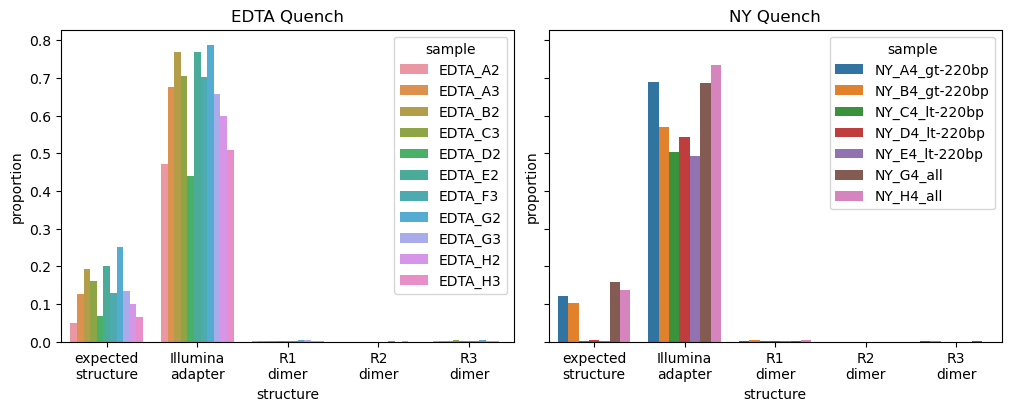

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=True, constrained_layout=True)
sns.barplot(
    df_group_analysis_r1 \
        .assign(structure=df_group_analysis_r1['structure'].str.replace(' ', '\n')) \
        .loc[df_group_analysis_r1['quench'] == 'EDTA'],
    x='structure',
    y='proportion',
    hue='sample',
    ax=axs[0]
)
axs[0].set_title('EDTA Quench')
sns.barplot(
    df_group_analysis_r1 \
        .assign(structure=df_group_analysis_r1['structure'].str.replace(' ', '\n')) \
        .loc[df_group_analysis_r1['quench'] == 'NY'],
    x='structure',
    y='proportion',
    hue='sample',
    ax=axs[1]
)
axs[1].set_title('NY Quench')
fig.show()

### Parse Read 2

In [79]:
path_config = os.path.join(DIR_AUX, 'splitcode_config-groups_only.tsv')

In [80]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"

for path_R2 in "$DIR_DATA"/*R2.fastq.gz; do
    SAMPLE="$(echo "$path_R2" | grep -o -E -e '(EDTA|NY)_[A-H][0-9]+.*_R2')"
    path_counts="${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv"

    if [ ! -f "$path_counts" ]; then
        splitcode -c "$PATH_CONFIG" \
            --nFastqs=1 --assign --loc-names --no-outb -t 8 \
            --mapping=/dev/null --output=/dev/stdout \
            "$path_R2" |
        awk '$1 ~ /^@/' |
        grep -o "LX:Z:.*" |
        sed -E -e 's/LX:Z://' -e 's/:0,/:/g' |
        sort |
        uniq -c |
        sed -E -e 's/^ *//' -e 's/ /\t/' |
        sort -n -r > "$path_counts"
    fi
done

* Using a list of 203 tags (vector size: 203; map size: 98,012; num elements in map: 99,152)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231204/scBarcode-EDTA_A2_R2.fastq.gz
* processing the reads ...
done 
* processed 26,090 reads, 24,223 reads were assigned
* Using a list of 203 tags (vector size: 203; map size: 98,012; num elements in map: 99,152)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231204/scBarcode-EDTA_A3_R2.fastq.gz
* processing the reads ...
done 
* processed 80,654 reads, 75,239 reads were assigned
* Using a list of 203 tags (vector size: 203; map size: 98,012; num elements in map: 99,152)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231204/scBarcode-EDTA_B2_R2.fastq.gz
* processing the reads ...
done 
* processed 35,361 reads, 33,225 reads were assigned
* Using a list of 203 tags (vector size: 203; map size: 98,012; num elements in map: 99,152)
* will process sample 1: /central/groups/gu

Proportion of reads matching expected structure

In [81]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_RESULTS} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_RESULTS="$3"
PATH_CONFIG="$4"

for path_R2 in "$DIR_DATA"/*R2.fastq.gz; do
    SAMPLE="$(echo "$path_R2" | grep -o -E -e '(EDTA|NY)_[A-H][0-9]+.*_R2')"
    path_analysis="${DIR_RESULTS}/tag_group_analysis-${SAMPLE}.csv"
    path_counts="${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv"

    total_reads=$(cat "$path_counts" | cut -f 1 | awk '{sum += $1} END {print sum}')

    echo -n "${SAMPLE},expected structure," > "$path_analysis"
    cat "$path_counts" |
        sed -E -e 's/:[0-9]+-[0-9]+//g' |
        grep -E -e "NYStgBot,R3,R3Bot,R2,R2Bot,R1,R1Bot,Even,([^,]+,){1,2}2Puni" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    echo -n "${SAMPLE},R1 dimer," >> "$path_analysis"
    cat "$path_counts" |
        grep -E -e "R1Bot:[0-9]+-([0-9]+),R1:\1-([0-9]+),R1Bot:\2-" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    echo -n "${SAMPLE},R2 dimer," >> "$path_analysis"
    cat "$path_counts" |
        grep -E -e "R2Bot:[0-9]+-([0-9]+),R2:\1-([0-9]+),R2Bot:\2-" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    echo -n "${SAMPLE},R3 dimer," >> "$path_analysis"
    cat "$path_counts" |
        grep -E -e "R3Bot:[0-9]+-([0-9]+),R3:\1-([0-9]+),R3Bot:\2-" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"
done

In [83]:
df_group_analysis_r2 = []
for sample in df_data['basename'].unique():
    path_analysis = os.path.join(DIR_RESULTS, f'tag_group_analysis-{sample}_R2.csv')
    df_group_analysis_r2.append(pd.read_csv(path_analysis, header=None, names=['sample', 'structure', 'count', 'total']))
df_group_analysis_r2 = (
    pd.concat(df_group_analysis_r2, axis=0)
    .fillna(0)
    .astype(dict(count=int, total=int))
    .pipe(lambda df: df.assign(
        proportion=df['count'] / df['total'],
        sample=df['sample'].str.replace('_R2$', '', regex=True)
    ))
    .merge(df_data[['basename', 'quench']].rename(columns={'basename': 'sample'}))
)

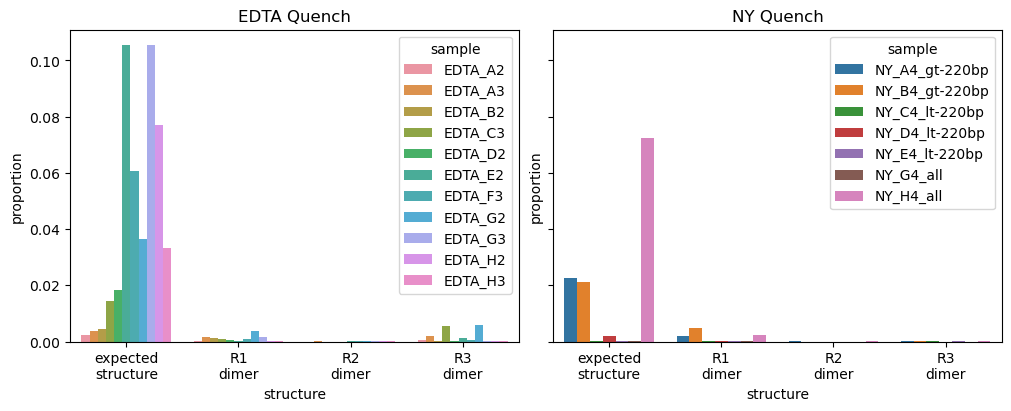

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=True, constrained_layout=True)
sns.barplot(
    df_group_analysis_r2 \
        .assign(structure=df_group_analysis_r2['structure'].str.replace(' ', '\n')) \
        .loc[df_group_analysis_r2['quench'] == 'EDTA'],
    x='structure',
    y='proportion',
    hue='sample',
    ax=axs[0]
)
axs[0].set_title('EDTA Quench')
sns.barplot(
    df_group_analysis_r2 \
        .assign(structure=df_group_analysis_r2['structure'].str.replace(' ', '\n')) \
        .loc[df_group_analysis_r2['quench'] == 'NY'],
    x='structure',
    y='proportion',
    hue='sample',
    ax=axs[1]
)
axs[1].set_title('NY Quench')
fig.show()

### Check for tags that are missing from this dataset

The R1, R2, or R3 have no missing tags, as expected.

Oddly, NYLigOdd tags 6, 11, 12, and 24 are rare/missing.

In [28]:
expected_tags = {
    'R1': set(range(1, 25)),
    'R2': set(range(1, 25)),
    'R3': set(range(1, 25))}

In [29]:
df_missing_tags = []
assert (df_tag_counts['count'] > 0).all()
for sample, group in df_tag_counts.groupby('sample'):
    for r in ROUNDS:
        missing_tags = expected_tags[r] - set(group.loc[group['round'] == r, 'tag'])
        rare_tags = set(group.loc[
            (group['round'] == r) &
            (group['deduplication'] == 'yes') &
            (group['count'] > 0) &
            (group['count'] < 50),
            'tag'])
        assert len(missing_tags & rare_tags) == 0
        df_missing_tags.append(dict(
            sample=sample,
            round=r,
            missing_tags=missing_tags,
            rare_tags=rare_tags))
df_missing_tags = pd.DataFrame(df_missing_tags).sort_values(['round', 'sample'])
df_missing_tags

sample round missing_tags               rare_tags
0      A3    R1           {}                      {}
3      A4    R1           {}                      {}
6      A5    R1           {}                      {}
9      B3    R1           {}                      {}
12     C3    R1           {}                      {}
15     C5    R1           {}                      {}
18     D3    R1           {}                      {}
1      A3    R2           {}                      {}
4      A4    R2           {}                      {}
7      A5    R2           {}                      {}
10     B3    R2           {}                      {}
13     C3    R2           {}                      {}
16     C5    R2           {}                      {}
19     D3    R2           {}                      {}
2      A3    R3           {}                      {}
5      A4    R3           {}                      {}
8      A5    R3           {}  {5, 7, 11, 18, 19, 24}
11     B3    R3           {}                      {}
14     C3    R3           {}                    {24}
17     C5    R3           {}                      {}
20     D3    R3           {}                     {2}

## Ligation QC

| Round    | Tags used (wells) | Tags used (ID) | Tags added during pooling | Pooling orientation     |
| -------- | ----------------- | -------------- | ------------------------- | ----------------------- |
| R1       | A1-A11, B1-B11    | 1-11, 13-23    | A12 (12), B12 (24)        | 12 apart                |
| R2       | C1-C11, D1-D11    | 1-11, 13-23    | C12 (12), D12 (24)        | symmetric around C12/D1 |
| R3       | E1-E11, F1-F11    | 1-11, 13-23    | E12 (12), F12 (24)        | 12 apart                |

## (TBD) Ligation of pooled tags

1. (Distribution over samples) For a given round, what proportion of tags were pooled tags?
2. (Distribution over samples) For a given round, what proportion of tags were accounted by each pooled tag?
4. (Distribution over samples) For a given partial (2 out of 3 rounds) barcode, what proportion of the "missing" round is made up of pooled tags?

In [46]:
df_pooled_tags_counts = (
    df_tag_counts
    .groupby(["sample", "round", "deduplication"], group_keys=False)
    .apply(lambda group: (
        group
        .assign(total=group["count"].sum())
        .loc[group["tag"].isin(rounds_to_pooled_tags[group.iloc[0]["round"]])]))
    .pipe(lambda df: df.assign(proportion=df['count']/df['total']))
    .sort_values(['deduplication', 'round', 'sample', 'proportion'])
    .reset_index(drop=True)
)

In [47]:
# assert that the number of counts observed at each round is the same for all samples
assert df_pooled_tags_counts.groupby(['sample', 'deduplication'])['total'].agg(lambda x: len(np.unique(x)) == 1).all()

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



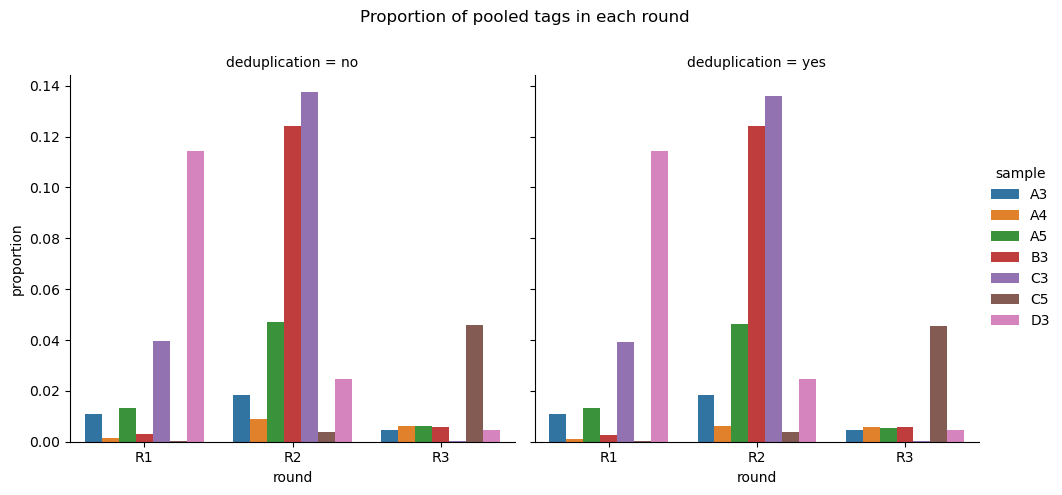

In [48]:
g = sns.catplot(
    df_pooled_tags_counts.groupby(['sample', 'round', 'deduplication'], as_index=False)['proportion'].sum(),
    kind='bar',
    x='round',
    y='proportion',
    hue='sample',
    col='deduplication')
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle('Proportion of pooled tags in each round')
g.figure.show()

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



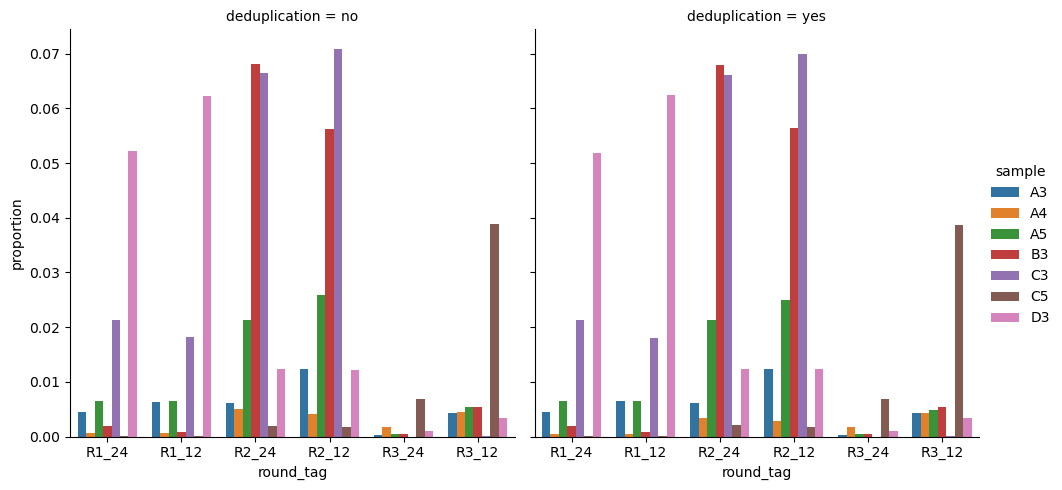

In [49]:
sns.catplot(
    df_pooled_tags_counts.assign(
        round_tag=df_pooled_tags_counts['round'].str.cat(df_pooled_tags_counts['tag'].astype(str), sep='_')),
    kind='bar',
    x='round_tag',
    y='proportion',
    hue='sample',
    col='deduplication')
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle('Proportion of pooled tags in each round')
g.figure.show()

In [50]:
df_pooled_tag_proportion_per_partial_barcode = []
for i in range(len(ROUNDS)):
    partial_rounds = ROUNDS[:i] + ROUNDS[i+1:]
    pooled_round = ROUNDS[i]
    df_pooled_tag_proportion_per_partial_barcode.append((
        df_barcode_counts
        .groupby(['sample'] + partial_rounds, observed=True, as_index=False)
        .apply(lambda group:
               group.loc[group[pooled_round].isin(rounds_to_pooled_tags[pooled_round]), ['count', 'count_dedup']].sum(axis=0) / 
               group[['count', 'count_dedup']].sum(axis=0))
        .assign(**{pooled_round: -1, 'round': pooled_round})
        .rename(columns={'count': 'proportion', 'count_dedup': 'proportion_dedup'})
    ))
df_pooled_tag_proportion_per_partial_barcode = pd.concat(df_pooled_tag_proportion_per_partial_barcode) \
    .astype(dict(round='category'))

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



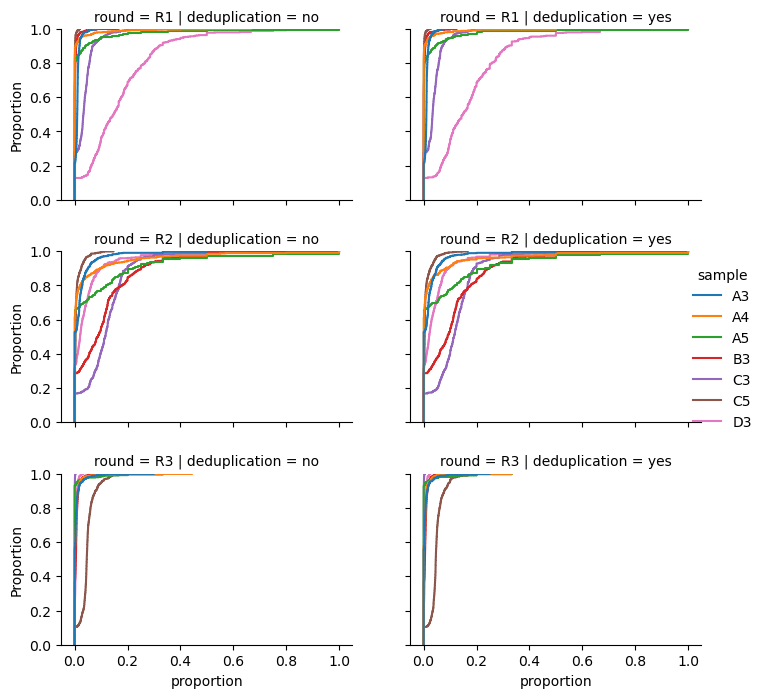

In [51]:
g = sns.displot(
    kind='ecdf',
    data=(
        df_pooled_tag_proportion_per_partial_barcode
        .rename(columns={'proportion': 'no', 'proportion_dedup': 'yes'}) \
        .melt(id_vars=['sample', 'round'],
              value_vars=['no', 'yes'],
              var_name='deduplication',
              value_name='proportion')),
    x='proportion',
    hue='sample',
    row='round',
    row_order=ROUNDS,
    col='deduplication',
    facet_kws={'gridspec_kws': dict(hspace=0.3)})
g.figure.set_size_inches((8, 8))

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



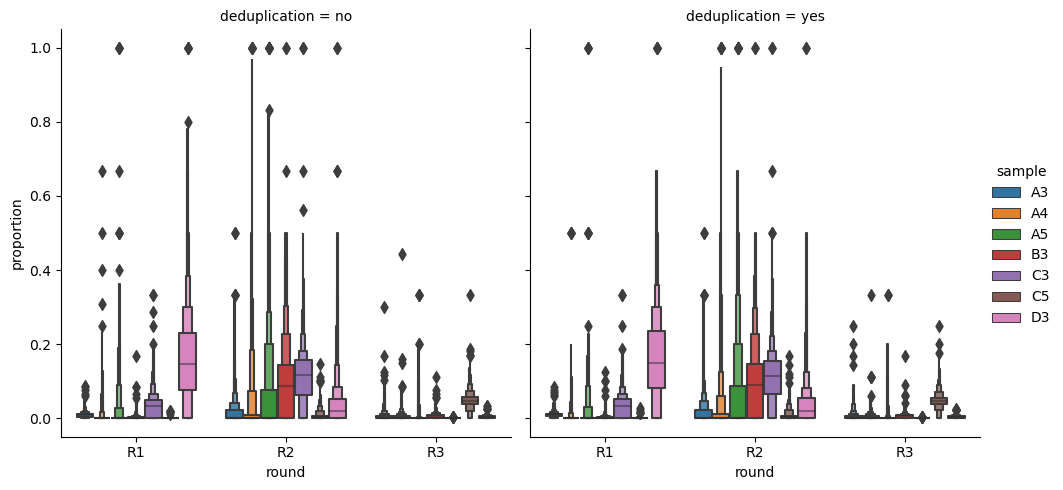

In [52]:
sns.catplot(
    kind='boxen',
    data=df_pooled_tag_proportion_per_partial_barcode \
        .rename(columns={'proportion': 'no', 'proportion_dedup': 'yes'}) \
        .melt(id_vars=['sample', 'round'],
              value_vars=['no', 'yes'],
              var_name='deduplication',
              value_name='proportion'),
    x='round',
    y='proportion',
    hue='sample',
    col='deduplication')

## (TBR) Independence of each round

In [53]:
df_rounds_independence = []
for r1, r2 in itertools.combinations(ROUNDS, 2):
    for sample, group in df_barcode_counts.groupby('sample'):
        pvalue = scipy.stats.chi2_contingency((
            group
            .groupby([r1, r2], observed=True, as_index=False)['count'].sum()
            .pivot(columns=r2, index=r1)
            .fillna(0)
            .values
        )).pvalue
        df_rounds_independence.append(dict(sample=sample, r1=r1, r2=r2, pvalue=pvalue))
df_rounds_independence = pd.DataFrame(df_rounds_independence)

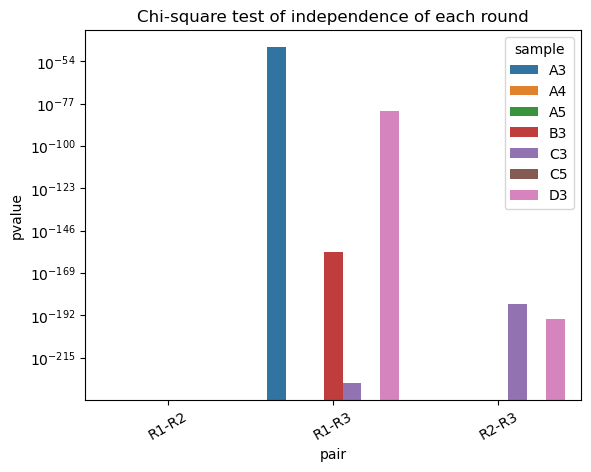

In [54]:
ax = sns.barplot(
    df_rounds_independence.assign(pair=df_rounds_independence['r1'].str.cat(df_rounds_independence['r2'], sep='-')),
    x='pair',
    y='pvalue',
    hue='sample')
ax.set_yscale('log')
ax.tick_params(axis='x', labelrotation=30)
ax.set_title('Chi-square test of independence of each round')
ax.figure.show()